In [1]:
import numpy as np
import scipy.linalg as la
from scipy.linalg import eig, qr, block_diag
from numpy.linalg import svd
import control
from scipy.linalg import null_space
import math
import matplotlib.pyplot as plt


def subspace_dist(Phi1,Phi2):
    S_comp = null_space(Phi2.T)
    return la.norm(Phi1.T@S_comp,2)


def zo2p(A, B, Q, R, K, r, ns, gamma):
    dx = A.shape[0]
    du = B.shape[1]
    K1 = []
    K2 = []
    cost_1 = []
    cost_2 = []
    grad = np.zeros((du, dx))
    Ul=[]
    for l in range(ns):
        U = np.random.randn(B.shape[1], A.shape[0])
        U = (U / np.linalg.norm(U))

        K1.append(K + r*U)
        K2.append(K - r*U)

        # Compute cost
        x_0 = np.random.normal(0, 1, size=(1,dx))[0]
        cost_1.append(cost_gamma_x0(A, B, Q, R, K1[-1],gamma,x_0))
        cost_2.append(cost_gamma_x0(A, B, Q, R, K2[-1],gamma,x_0))
        Ul.append(U)

        grad += ((dx * du) / (2 * ns * (r))) * (cost_1[l] - cost_2[l]) * Ul[l]

    return grad


def cost_gamma(A, B, Q, R, K, gamma):
        dx = A.shape[0]
        tau = 50
        ns = 100
        cost = 0
        for i in range(ns):
            cost_i = 0
            x = np.random.normal(0, 1, size=(1,dx))[0]
            for t in range(tau):
                u = -K@x
                cost_i += (gamma**t)*(x.T@Q@x + u.T@R@u)
                x = (A-B@K)@x
            cost+=(1/ns)*cost_i  
        
        return cost
    
    
def cost_gamma_x0(A, B, Q, R, K, gamma, x):
        dx = A.shape[0]
        tau = 50
        cost = 0
        for t in range(tau):
            u = -K@x
            cost += (gamma**t)*(x.T@Q@x + u.T@R@u)
            x = (A-B@K)@x
        return cost
    
    
def find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi):
    dx = A.shape[0]
    du = B.shape[1]
    K = np.zeros((du,dx))
    sr = []
    gammas = []
    k = 0
    flag = 0
    k0 = 0
    while gamma<1:
        
        sr.append(max(abs(la.eigvals(A-B@K))))
        gammas.append(gamma)
        print(f"Iteration: {k}, Spectral radius: {sr[-1]}, gamma: {gammas[-1]}")
        K_l = K
        for n in range(N):
            K_l=K_l - eta*zo2p(A, B, Q, R, K_l, r, ns, gamma)
        K = K_l
        eta = 0.98*eta
        #Update the discount factor
        sigma_min = min(abs(la.eigvals(Q + K.T@R@K)))
        alpha = sigma_min/(2*cost_gamma(A, B, Q, R, K, gamma) - sigma_min)
        gamma = (1+alpha*xi)*gamma
        if gamma>=1:
            gammas.append(gamma)
            break
        k+=1
    return K, sr, gammas

def find_stabilizing_ld(A,B,Q,R,gamma,N,r,ns,eta,Phi,A_hd,B_hd,xi):
    eta0 = eta
    dx = A.shape[0]
    du = B.shape[1]
    K = np.zeros((du,dx))
    sr_ld = []
    sr_hd = []
    gammas = []
    k = 0
    k0 = 0
    flag = 0
    while gamma<1:
        sr_ld.append(max(abs(la.eigvals(A-B@K))))
        sr_hd.append(max(abs(la.eigvals(A_hd-B_hd@K@Phi.T))))

        gammas.append(gamma)
        print(f"Iteration: {k}, Spectral radius: {sr_ld[-1]}, gamma: {gammas[-1]}")
        K_l = K
        #Local updates:
        for n in range(N):
            K_l=K_l - eta*zo2p(A, B, Q, R, K_l, r, ns, gamma)
        K = K_l
        eta = 0.98*eta
        #Update the discount factor
        sigma_min = min(abs(la.eigvals(Q + K.T@R@K)))
        alpha = sigma_min/(2*cost_gamma(A, B, Q, R, K, gamma) - sigma_min)
        gamma = (1+alpha*xi)*gamma
        if gamma>=1:
            gammas.append(gamma)
            break
        k+=1
    return K, sr_ld, sr_hd, gammas

def simulate_system(A,x):
    return A @ x

def get_basis(A):
    e_i_p = []
    for i in range(dx):
        e_i = np.zeros(dx)
        e_i[i] = 1
        e_i_p.append(simulate_system(A,e_i))
    return e_i_p

def adjoint_data(x0,T,e_i_p):
    dx = x0.shape[0]
    X = np.zeros((dx,T))
    x = x0
    for t in range(T):
        x_adj = np.zeros(dx)
        for i in range(dx):
            x_adj[i] = np.dot(e_i_p[i], x)
        x = x_adj
        X[:,t] = x.reshape(dx,)    
    return X

$\textbf{LTI system:}$

$\textbf{Cartpole:}$

In [51]:
l = 3 #number of unstable modes
d0 = 4
du = 1

#mc = 1, mp = 1, l = 1
#dt = 0.25, g = 10

A0 = np.array([[ 1.  ,  0.25,  0.  ,  0.  ],
               [ 0.  ,  1.  , -2.5 ,  0.  ],
               [ 0.  ,  0.  ,  1.  ,  0.25],
               [ 0.  ,  0.  ,  5.  ,  1.  ]])

B0 = np.array([[ 0.  ],
               [ 0.25],
               [ 0.  ],
               [-0.25]])

In [66]:
nr = 5 #number of realizations

$\textbf{Case 1: (Algorithm 1)}\;\ dx = 30, \ell = 3$

In [74]:
dx = 30
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 1e-2
xi = 0.9
srs1 = []
gammas1 = []
x = np.ones((dx,1))
for i in range(nr):
    
    #Augmenting the nominal system
    A_tilde = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.5*(A_tilde+A_tilde.T)/la.norm(A_tilde+A_tilde.T,2))

    #Bs = np.zeros((dx-d0,du))
    B_tilde = np.random.randn(dx-d0,du)
    Bs = 0.5*B_tilde/la.norm(B_tilde,2)
    B = np.concatenate((B0, Bs), axis=0)
    
    #Learning the left unstable subspce
    T = 40 #horizon length
    e_i_p = get_basis(A)
    D = adjoint_data(x,T,e_i_p)
    U,S,V = svd(D)
    Phi_hat = U[:,:l]
    x = np.random.rand(dx,1)
    Au = Phi_hat.T@A@Phi_hat
    Bu = Phi_hat.T@B
    Qu = Phi_hat.T@(100*np.eye(dx))@Phi_hat
    R = np.eye(du)
    print(f"Realization: {i}")
    K,_,sr1,gamms = find_stabilizing_ld(Au,Bu,Qu,R,gamma,N,r,ns,eta,Phi_hat,A,B,xi)
    print("-----------------")
    srs1.append(sr1)
    gammas1.append(gamms)

Realization: 0
Iteration: 0, Spectral radius: 2.1180339887498976, gamma: 0.1
Iteration: 1, Spectral radius: 2.046705570989887, gamma: 0.11388841481386656
Iteration: 2, Spectral radius: 2.008162633864945, gamma: 0.1268883109400104
Iteration: 3, Spectral radius: 1.979748566283353, gamma: 0.14286473169050168
Iteration: 4, Spectral radius: 1.9482784467073233, gamma: 0.15716372689390157
Iteration: 5, Spectral radius: 1.9230792421853635, gamma: 0.17220874265025898
Iteration: 6, Spectral radius: 1.8946092490603967, gamma: 0.1880083451913861
Iteration: 7, Spectral radius: 1.8613010140831254, gamma: 0.20312237668309419
Iteration: 8, Spectral radius: 1.821897531039336, gamma: 0.2184430381115733
Iteration: 9, Spectral radius: 1.7806403589540545, gamma: 0.23230392054240465
Iteration: 10, Spectral radius: 1.7425825137635322, gamma: 0.2456463594009095
Iteration: 11, Spectral radius: 1.70146815044059, gamma: 0.2594551585646542
Iteration: 12, Spectral radius: 1.6584443082282259, gamma: 0.2707167395867

Iteration: 110, Spectral radius: 0.833400707289832, gamma: 0.7669224362807529
Iteration: 111, Spectral radius: 0.8300474818664348, gamma: 0.7698935469279007
Iteration: 112, Spectral radius: 0.8255262921983515, gamma: 0.7741725642348586
Iteration: 113, Spectral radius: 0.8235116746062535, gamma: 0.777387547247036
Iteration: 114, Spectral radius: 0.8237382569249717, gamma: 0.7810170454102009
Iteration: 115, Spectral radius: 0.8212265383586121, gamma: 0.7846864985430321
Iteration: 116, Spectral radius: 0.8188142425002823, gamma: 0.7883011517953122
Iteration: 117, Spectral radius: 0.8153179662756217, gamma: 0.7919086315212389
Iteration: 118, Spectral radius: 0.8181299973777565, gamma: 0.7951420799586079
Iteration: 119, Spectral radius: 0.8133653264487437, gamma: 0.7986475855989407
Iteration: 120, Spectral radius: 0.8161436379058371, gamma: 0.8018853977841783
Iteration: 121, Spectral radius: 0.8115717320797947, gamma: 0.8055782500098015
Iteration: 122, Spectral radius: 0.8130133198492423, g

Iteration: 28, Spectral radius: 1.2826646024704134, gamma: 0.39765802185816707
Iteration: 29, Spectral radius: 1.2699957970676228, gamma: 0.40418841003347883
Iteration: 30, Spectral radius: 1.2564717547570314, gamma: 0.41026676799696393
Iteration: 31, Spectral radius: 1.2399712210797853, gamma: 0.41611231623288814
Iteration: 32, Spectral radius: 1.2273132007352248, gamma: 0.42185980563002307
Iteration: 33, Spectral radius: 1.2167942900719333, gamma: 0.4290043991457511
Iteration: 34, Spectral radius: 1.2014909587249492, gamma: 0.43393800583726433
Iteration: 35, Spectral radius: 1.1907033962230462, gamma: 0.43883111904044414
Iteration: 36, Spectral radius: 1.1855901800595936, gamma: 0.4443180739594951
Iteration: 37, Spectral radius: 1.1749416820637846, gamma: 0.45013773147591807
Iteration: 38, Spectral radius: 1.1629027046201066, gamma: 0.45506193586181565
Iteration: 39, Spectral radius: 1.152855464014772, gamma: 0.4610982188313794
Iteration: 40, Spectral radius: 1.141460390995292, gamma

Iteration: 133, Spectral radius: 0.8310237999817917, gamma: 0.8120445260614911
Iteration: 134, Spectral radius: 0.82772036362908, gamma: 0.8146942584637186
Iteration: 135, Spectral radius: 0.8297301519999403, gamma: 0.8175181843644844
Iteration: 136, Spectral radius: 0.8278499711165132, gamma: 0.819808817822121
Iteration: 137, Spectral radius: 0.82758985308432, gamma: 0.8222575712616
Iteration: 138, Spectral radius: 0.8253431051107898, gamma: 0.825594418836964
Iteration: 139, Spectral radius: 0.8240310886422543, gamma: 0.8286285748313602
Iteration: 140, Spectral radius: 0.8232748276615356, gamma: 0.8313328469642355
Iteration: 141, Spectral radius: 0.8210935830260956, gamma: 0.8341782189889958
Iteration: 142, Spectral radius: 0.8219200761537646, gamma: 0.8372403043990937
Iteration: 143, Spectral radius: 0.8200433452793932, gamma: 0.8402634700376196
Iteration: 144, Spectral radius: 0.8167348413972484, gamma: 0.8430068975061641
Iteration: 145, Spectral radius: 0.8156554586448653, gamma: 0

Iteration: 30, Spectral radius: 1.2398546170665403, gamma: 0.4147494082549942
Iteration: 31, Spectral radius: 1.2237399953241603, gamma: 0.42085690739702625
Iteration: 32, Spectral radius: 1.2120805747777592, gamma: 0.42558062281655235
Iteration: 33, Spectral radius: 1.2033102138510956, gamma: 0.432051915444066
Iteration: 34, Spectral radius: 1.1928066893574816, gamma: 0.43801431183907613
Iteration: 35, Spectral radius: 1.1804216086034687, gamma: 0.44430881274863715
Iteration: 36, Spectral radius: 1.16988124031464, gamma: 0.45199669916994933
Iteration: 37, Spectral radius: 1.1587072729553984, gamma: 0.45946121444188315
Iteration: 38, Spectral radius: 1.1469583328524648, gamma: 0.4655379796299731
Iteration: 39, Spectral radius: 1.135657737788389, gamma: 0.4718649347007499
Iteration: 40, Spectral radius: 1.129782166569582, gamma: 0.4766292577828741
Iteration: 41, Spectral radius: 1.1198013521852108, gamma: 0.48216480377383136
Iteration: 42, Spectral radius: 1.113518453090161, gamma: 0.48

Iteration: 138, Spectral radius: 0.830184224767767, gamma: 0.8601411891018781
Iteration: 139, Spectral radius: 0.8280936361659442, gamma: 0.8627375099520833
Iteration: 140, Spectral radius: 0.829856593982713, gamma: 0.865502126317311
Iteration: 141, Spectral radius: 0.8276244181616049, gamma: 0.8688938479339041
Iteration: 142, Spectral radius: 0.8287127928312674, gamma: 0.8717747088112816
Iteration: 143, Spectral radius: 0.8242877415326684, gamma: 0.8745210428996575
Iteration: 144, Spectral radius: 0.8223510393630302, gamma: 0.8764873906541352
Iteration: 145, Spectral radius: 0.8224521040356753, gamma: 0.8803578268903012
Iteration: 146, Spectral radius: 0.8199145140773291, gamma: 0.8835746949340754
Iteration: 147, Spectral radius: 0.8214078446383843, gamma: 0.8861131870060005
Iteration: 148, Spectral radius: 0.81755735549118, gamma: 0.8894239411261698
Iteration: 149, Spectral radius: 0.8170445608308815, gamma: 0.8920112714734634
Iteration: 150, Spectral radius: 0.8159061642051114, gamm

Iteration: 51, Spectral radius: 1.058249675942617, gamma: 0.5249801684874348
Iteration: 52, Spectral radius: 1.051584360111326, gamma: 0.5311599524345336
Iteration: 53, Spectral radius: 1.043072321444545, gamma: 0.5364645006264765
Iteration: 54, Spectral radius: 1.0458221281131175, gamma: 0.5438898382308216
Iteration: 55, Spectral radius: 1.0316794525937154, gamma: 0.5485438365066064
Iteration: 56, Spectral radius: 1.0278879534505272, gamma: 0.553101578056462
Iteration: 57, Spectral radius: 1.022246847048756, gamma: 0.5577335699516018
Iteration: 58, Spectral radius: 1.012341947766021, gamma: 0.562678629092871
Iteration: 59, Spectral radius: 1.004722183367277, gamma: 0.5662431711229453
Iteration: 60, Spectral radius: 1.0041084061440295, gamma: 0.5702663708067054
Iteration: 61, Spectral radius: 0.9988748597820549, gamma: 0.5743064598129958
Iteration: 62, Spectral radius: 0.9960843654341938, gamma: 0.5790480571039238
Iteration: 63, Spectral radius: 0.993635681004917, gamma: 0.582627641810

Iteration: 157, Spectral radius: 0.8074727507021555, gamma: 0.8896690807950116
Iteration: 158, Spectral radius: 0.8059328922450759, gamma: 0.8916542234813357
Iteration: 159, Spectral radius: 0.804696392730322, gamma: 0.8944647895072517
Iteration: 160, Spectral radius: 0.8049653185194132, gamma: 0.8973906894228489
Iteration: 161, Spectral radius: 0.8017946220024763, gamma: 0.8998559206750936
Iteration: 162, Spectral radius: 0.8010780071087773, gamma: 0.9022705908960453
Iteration: 163, Spectral radius: 0.8027320520783752, gamma: 0.9050406803257393
Iteration: 164, Spectral radius: 0.8017520567621649, gamma: 0.9082194708119726
Iteration: 165, Spectral radius: 0.799603325394323, gamma: 0.9113239027146104
Iteration: 166, Spectral radius: 0.8001748320099998, gamma: 0.9138499713980116
Iteration: 167, Spectral radius: 0.7960749965384326, gamma: 0.9163185775451514
Iteration: 168, Spectral radius: 0.7961602592456052, gamma: 0.9186885030259978
Iteration: 169, Spectral radius: 0.7937462705379408, g

Iteration: 59, Spectral radius: 1.022717230712909, gamma: 0.5722217766737403
Iteration: 60, Spectral radius: 1.0175423030111572, gamma: 0.5765420641474667
Iteration: 61, Spectral radius: 1.0170803155791595, gamma: 0.5806531341748171
Iteration: 62, Spectral radius: 1.0109933063827752, gamma: 0.5849830462189055
Iteration: 63, Spectral radius: 1.0060552447244757, gamma: 0.5896085829603123
Iteration: 64, Spectral radius: 1.004004723015611, gamma: 0.5935666397657227
Iteration: 65, Spectral radius: 0.9992662558568907, gamma: 0.5974217652243243
Iteration: 66, Spectral radius: 0.995832145079685, gamma: 0.602206312121517
Iteration: 67, Spectral radius: 0.9911812235331912, gamma: 0.6065433946915699
Iteration: 68, Spectral radius: 0.9884267849930664, gamma: 0.6107145507058834
Iteration: 69, Spectral radius: 0.9880301244168379, gamma: 0.6153624657108347
Iteration: 70, Spectral radius: 0.9825802899784305, gamma: 0.618996637214017
Iteration: 71, Spectral radius: 0.9751602614065862, gamma: 0.62319590

Iteration: 164, Spectral radius: 0.8094089178026629, gamma: 0.9064395220799203
Iteration: 165, Spectral radius: 0.8095160835817, gamma: 0.9095083998375371
Iteration: 166, Spectral radius: 0.8084967164141857, gamma: 0.9125192602106261
Iteration: 167, Spectral radius: 0.806164088329584, gamma: 0.9148995606152046
Iteration: 168, Spectral radius: 0.8043075866349305, gamma: 0.9173067511826575
Iteration: 169, Spectral radius: 0.8045230122997786, gamma: 0.9194955515929086
Iteration: 170, Spectral radius: 0.8022225687782625, gamma: 0.9219969906066562
Iteration: 171, Spectral radius: 0.8021578812002658, gamma: 0.9248810827998107
Iteration: 172, Spectral radius: 0.8003479267435537, gamma: 0.9271100810989779
Iteration: 173, Spectral radius: 0.7991264714768388, gamma: 0.9300024955920326
Iteration: 174, Spectral radius: 0.7968381579134383, gamma: 0.9330246496217646
Iteration: 175, Spectral radius: 0.7973455341688276, gamma: 0.9347769528719397
Iteration: 176, Spectral radius: 0.7933621368052653, gam

In [75]:
dimg = 1e10
for i in range(nr):
    dimg = min(len(gammas1[i]),dimg) 
    
dimsr = 1e10
for i in range(nr):
    dimsr = min(len(srs1[i]),dimsr) 


gammas1r = np.zeros((nr,dimg))
sr1s = np.zeros((nr,dimsr))
for i in range(nr):
    gammas1r[i,:] = gammas1[i][:dimg]
    sr1s[i,:] = srs1[i][:dimsr]

$\textbf{Closed-loop spectral radius:}$

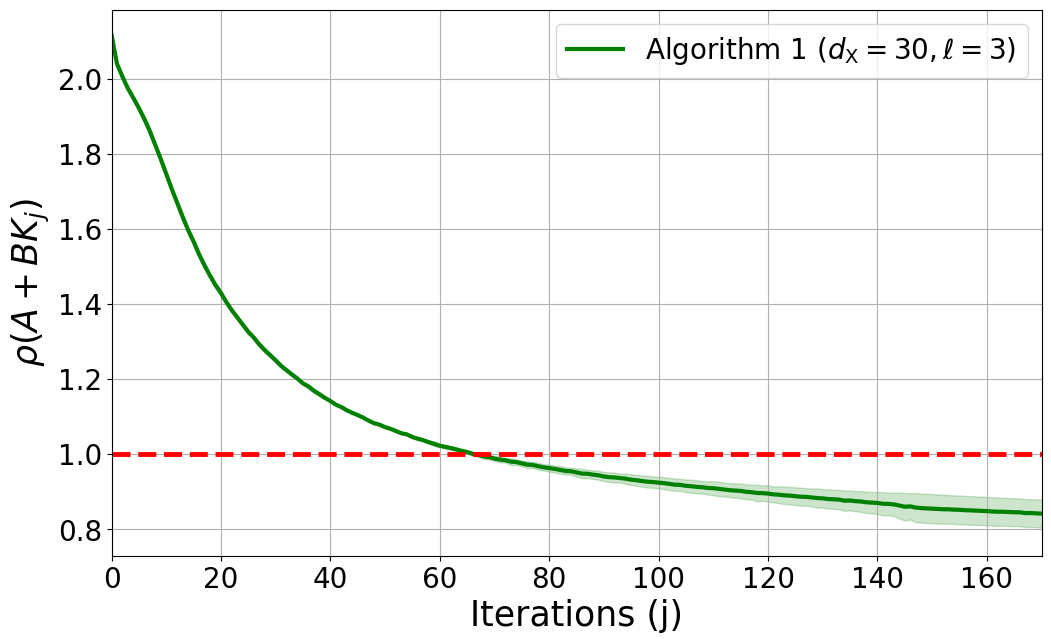

In [76]:
plt.figure(figsize=(12,7))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(sr1s, axis=0)
sem_1 = np.std(sr1s, axis=0) / np.sqrt(sr1s.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 30, \ell = 3)$', color='green', linewidth=3)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)
plt.plot(np.arange(dimsr), np.ones(dimsr), linestyle='--', color='red', linewidth=3.5)


plt.ylabel(r'$\rho(A+BK_{j})$',fontsize=25)
plt.xlabel('Iterations (j)',fontsize=25)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(0, 170)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.10)
plt.grid()

$\textbf{Discount factor:}$

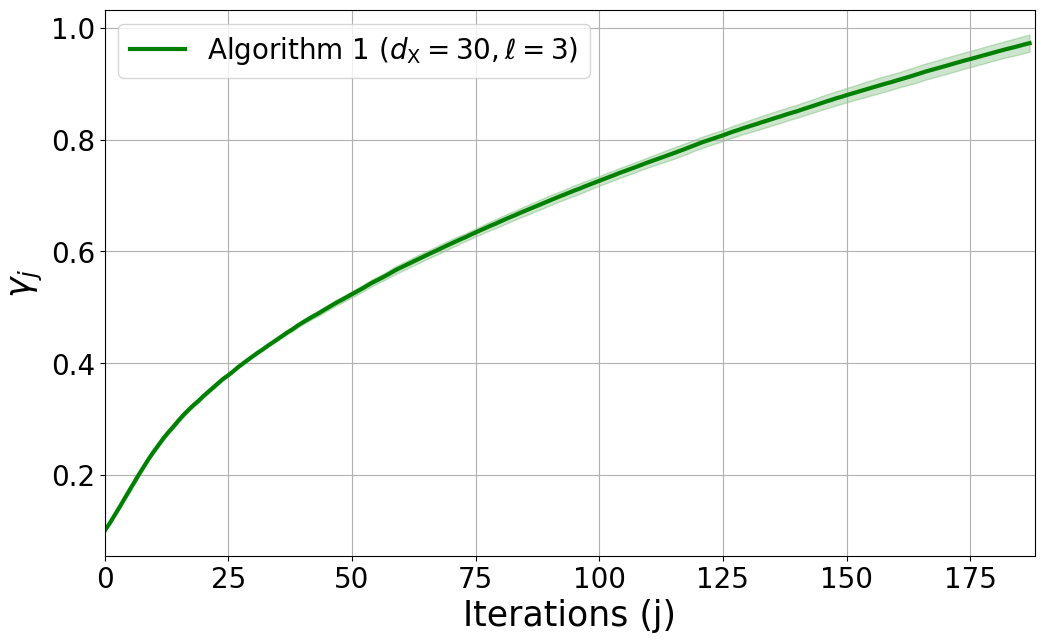

In [77]:
plt.figure(figsize=(12,7))



# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(gammas1r, axis=0)
sem_1 = np.std(gammas1r, axis=0) / np.sqrt(gammas1r.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1 $(d_{\mathsf{X}} = 30, \ell = 3)$', color='green', linewidth=3)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plt.ylabel(r'$\gamma_j$',fontsize=25)
plt.xlabel('Iterations (j)',fontsize=25)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(0, dimg)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels,fontsize=20)
plt.subplots_adjust(bottom=0.10)
plt.grid()

$\textbf{Case 2: (LTS all modes)}\;\ dx = 30, \ell = 3$

In [57]:
dx = 30
#Algorithm parameters 
gamma = 0.1
ns = 20
r = 1e-3
N = 20
eta = 3e-3
xi = 0.9
srs2 = []
gammas2 = []
for i in range(nr):
    
    #Augmenting the nominal system
    A_tilde = np.random.randn(dx-d0,dx-d0)
    A = block_diag(A0, 0.5*(A_tilde+A_tilde.T)/la.norm(A_tilde+A_tilde.T,2))

    B_tilde = np.random.randn(dx-d0,du)
    Bs = 0.5*B_tilde/la.norm(B_tilde,2)
    B = np.concatenate((B0, Bs), axis=0)
    
    Q = 100*np.eye(dx)
    R = np.eye(du)
    
    print(f"Realization: {i}")
    K,sr2,gamms2 = find_stabilizing_hd(A,B,Q,R,gamma,N,r,ns,eta,xi)
    print("-----------------")
    srs2.append(sr2)
    gammas2.append(gamms2)

Realization: 0
Iteration: 0, Spectral radius: 2.118033988749895, gamma: 0.1
Iteration: 1, Spectral radius: 1.8982262857212338, gamma: 0.1012277809578275
Iteration: 2, Spectral radius: 1.8827995874018533, gamma: 0.102561097643339
Iteration: 3, Spectral radius: 1.893342843468284, gamma: 0.10387855001323378
Iteration: 4, Spectral radius: 1.8243599933176826, gamma: 0.1052405121664376
Iteration: 5, Spectral radius: 1.88996784652123, gamma: 0.10659253237697297
Iteration: 6, Spectral radius: 1.8776835956120912, gamma: 0.10804861676332868
Iteration: 7, Spectral radius: 1.8587437499373545, gamma: 0.10944406142435731
Iteration: 8, Spectral radius: 1.866101516001254, gamma: 0.11083520032339683
Iteration: 9, Spectral radius: 1.8638044839997843, gamma: 0.11228038278700754
Iteration: 10, Spectral radius: 1.8686141095679245, gamma: 0.11371451951413855
Iteration: 11, Spectral radius: 1.8658451064365784, gamma: 0.1151866445778811
Iteration: 12, Spectral radius: 1.8761655564137731, gamma: 0.116692312683

Iteration: 105, Spectral radius: 1.5354699169717134, gamma: 0.2967767666568526
Iteration: 106, Spectral radius: 1.5264565341155312, gamma: 0.2985533362052839
Iteration: 107, Spectral radius: 1.5239860264534308, gamma: 0.3003490181803344
Iteration: 108, Spectral radius: 1.5222626356658284, gamma: 0.3020989629653313
Iteration: 109, Spectral radius: 1.5148305013334689, gamma: 0.30407382117921455
Iteration: 110, Spectral radius: 1.5079252050756442, gamma: 0.3059118186181174
Iteration: 111, Spectral radius: 1.5051078591947147, gamma: 0.3077833554095972
Iteration: 112, Spectral radius: 1.5047089907181643, gamma: 0.30955488780723517
Iteration: 113, Spectral radius: 1.4931651677346232, gamma: 0.311466796273382
Iteration: 114, Spectral radius: 1.489443795843742, gamma: 0.3134100723582413
Iteration: 115, Spectral radius: 1.4877775818336567, gamma: 0.315164842339228
Iteration: 116, Spectral radius: 1.4804581516151665, gamma: 0.3168843197746668
Iteration: 117, Spectral radius: 1.4810273310006994, 

Iteration: 209, Spectral radius: 1.152301399848736, gamma: 0.456446866659283
Iteration: 210, Spectral radius: 1.1447675062550977, gamma: 0.45774831967150864
Iteration: 211, Spectral radius: 1.1520324535295141, gamma: 0.45910409345778447
Iteration: 212, Spectral radius: 1.1395536588655544, gamma: 0.4605054357299692
Iteration: 213, Spectral radius: 1.150576617872984, gamma: 0.4618158768801914
Iteration: 214, Spectral radius: 1.1507540078699483, gamma: 0.4631645733831661
Iteration: 215, Spectral radius: 1.1505339231856793, gamma: 0.4642096763074784
Iteration: 216, Spectral radius: 1.1513004595344731, gamma: 0.4654906035462012
Iteration: 217, Spectral radius: 1.1487219386769896, gamma: 0.46693202867480876
Iteration: 218, Spectral radius: 1.1497538988265796, gamma: 0.46814516028719333
Iteration: 219, Spectral radius: 1.1436257297312948, gamma: 0.4693762025655651
Iteration: 220, Spectral radius: 1.1399054622532088, gamma: 0.470494239073412
Iteration: 221, Spectral radius: 1.1340094382172181,

Iteration: 313, Spectral radius: 0.9892197059897399, gamma: 0.5768286356809548
Iteration: 314, Spectral radius: 0.9853281004948246, gamma: 0.5779368374883846
Iteration: 315, Spectral radius: 0.9861677105052649, gamma: 0.5790366962973402
Iteration: 316, Spectral radius: 0.9794691935428007, gamma: 0.5798593961489888
Iteration: 317, Spectral radius: 0.9834572339081926, gamma: 0.5807096888434982
Iteration: 318, Spectral radius: 0.9839798129067585, gamma: 0.5816071401540002
Iteration: 319, Spectral radius: 0.9848118288883856, gamma: 0.5824382238863934
Iteration: 320, Spectral radius: 0.9869331808729055, gamma: 0.583601066990404
Iteration: 321, Spectral radius: 0.9849775530238064, gamma: 0.5844685292879354
Iteration: 322, Spectral radius: 0.9842393447522284, gamma: 0.5855633753756313
Iteration: 323, Spectral radius: 0.9865261202563792, gamma: 0.5866496323021752
Iteration: 324, Spectral radius: 0.9910755862353152, gamma: 0.5881023248946531
Iteration: 325, Spectral radius: 0.9929916127646506, 

Iteration: 417, Spectral radius: 0.96388999950789, gamma: 0.6715963213227063
Iteration: 418, Spectral radius: 0.9636865056105036, gamma: 0.672532991629857
Iteration: 419, Spectral radius: 0.9626783188619019, gamma: 0.6731679289730896
Iteration: 420, Spectral radius: 0.9623140406133321, gamma: 0.6739308973920574
Iteration: 421, Spectral radius: 0.9606903603428143, gamma: 0.6747313678277636
Iteration: 422, Spectral radius: 0.9611380062291464, gamma: 0.6755012877583499
Iteration: 423, Spectral radius: 0.9609802704517055, gamma: 0.6763493078856714
Iteration: 424, Spectral radius: 0.9613387226512612, gamma: 0.6773421533803585
Iteration: 425, Spectral radius: 0.9601887509498238, gamma: 0.6782169590213143
Iteration: 426, Spectral radius: 0.9594917060333225, gamma: 0.6791559699971542
Iteration: 427, Spectral radius: 0.9577661285091054, gamma: 0.6801132160170449
Iteration: 428, Spectral radius: 0.9572907900375613, gamma: 0.680927510909161
Iteration: 429, Spectral radius: 0.9554398683267896, gam

Iteration: 522, Spectral radius: 0.949478355705774, gamma: 0.7500424916333709
Iteration: 523, Spectral radius: 0.9492840879440637, gamma: 0.7507649363636881
Iteration: 524, Spectral radius: 0.9493845710534623, gamma: 0.7514885973491574
Iteration: 525, Spectral radius: 0.9495973222339786, gamma: 0.7521807019552872
Iteration: 526, Spectral radius: 0.9494056315491418, gamma: 0.7528736672856209
Iteration: 527, Spectral radius: 0.9492179074405566, gamma: 0.7535173304634413
Iteration: 528, Spectral radius: 0.9492332155408876, gamma: 0.7542862163664346
Iteration: 529, Spectral radius: 0.9492341888363703, gamma: 0.7549778262175365
Iteration: 530, Spectral radius: 0.9487516096188924, gamma: 0.7557379856975899
Iteration: 531, Spectral radius: 0.9486904128884862, gamma: 0.7564934320428394
Iteration: 532, Spectral radius: 0.9482777150288685, gamma: 0.7571190309309256
Iteration: 533, Spectral radius: 0.9483688834513777, gamma: 0.7576717075790588
Iteration: 534, Spectral radius: 0.9484479024574918, 

Iteration: 626, Spectral radius: 0.9417131171988955, gamma: 0.8130641534862451
Iteration: 627, Spectral radius: 0.9417157310459049, gamma: 0.8136516000843632
Iteration: 628, Spectral radius: 0.9415920758497011, gamma: 0.8141954756772419
Iteration: 629, Spectral radius: 0.941537386855255, gamma: 0.8147558496473126
Iteration: 630, Spectral radius: 0.9414052204732027, gamma: 0.8152711133622885
Iteration: 631, Spectral radius: 0.9413369247118303, gamma: 0.8157664402568569
Iteration: 632, Spectral radius: 0.9413396545822977, gamma: 0.8162092720606348
Iteration: 633, Spectral radius: 0.9412724236795361, gamma: 0.8168844912518101
Iteration: 634, Spectral radius: 0.9412029606294918, gamma: 0.817356891562962
Iteration: 635, Spectral radius: 0.9411692603329633, gamma: 0.8180010343163865
Iteration: 636, Spectral radius: 0.9411043059231142, gamma: 0.8184685937299321
Iteration: 637, Spectral radius: 0.9411087808458622, gamma: 0.8188549351533935
Iteration: 638, Spectral radius: 0.9410849327403934, g

Iteration: 730, Spectral radius: 0.9369390107212834, gamma: 0.8648894246239032
Iteration: 731, Spectral radius: 0.9368964943251337, gamma: 0.8653473197535775
Iteration: 732, Spectral radius: 0.9368434130030243, gamma: 0.8657854573315058
Iteration: 733, Spectral radius: 0.9368144390686253, gamma: 0.8662414688997092
Iteration: 734, Spectral radius: 0.9367925569153441, gamma: 0.8666993971263959
Iteration: 735, Spectral radius: 0.936768177818187, gamma: 0.8671419954596703
Iteration: 736, Spectral radius: 0.9367401908848677, gamma: 0.8675416503763147
Iteration: 737, Spectral radius: 0.9367090790544096, gamma: 0.868015573071467
Iteration: 738, Spectral radius: 0.9366617224914165, gamma: 0.8684622431926223
Iteration: 739, Spectral radius: 0.9366218440675764, gamma: 0.8688748644516332
Iteration: 740, Spectral radius: 0.9365772141418981, gamma: 0.8692612801103775
Iteration: 741, Spectral radius: 0.9365356431741542, gamma: 0.8697243532636093
Iteration: 742, Spectral radius: 0.936504825643177, ga

Iteration: 834, Spectral radius: 0.9346782592557437, gamma: 0.9078485197865571
Iteration: 835, Spectral radius: 0.9346605630662133, gamma: 0.9081405843708762
Iteration: 836, Spectral radius: 0.9346476347145397, gamma: 0.9085929175443487
Iteration: 837, Spectral radius: 0.9346271849080066, gamma: 0.9090152775092892
Iteration: 838, Spectral radius: 0.9346172893744222, gamma: 0.909410814704069
Iteration: 839, Spectral radius: 0.9345976787674793, gamma: 0.9097510388761652
Iteration: 840, Spectral radius: 0.9345866646261454, gamma: 0.9101448566510826
Iteration: 841, Spectral radius: 0.9345665831893708, gamma: 0.9104566313967963
Iteration: 842, Spectral radius: 0.9345534256219007, gamma: 0.9108199709292084
Iteration: 843, Spectral radius: 0.9345422271848912, gamma: 0.911139976996036
Iteration: 844, Spectral radius: 0.9345325809056066, gamma: 0.9114313747978986
Iteration: 845, Spectral radius: 0.9345178883759332, gamma: 0.9118493834357511
Iteration: 846, Spectral radius: 0.9345078400433243, g

Iteration: 939, Spectral radius: 0.9338247765019672, gamma: 0.9431353021193437
Iteration: 940, Spectral radius: 0.9338190969231951, gamma: 0.9434790578046194
Iteration: 941, Spectral radius: 0.9338146906913289, gamma: 0.9437561199024712
Iteration: 942, Spectral radius: 0.9338109205292427, gamma: 0.9441515116389093
Iteration: 943, Spectral radius: 0.9338069138938841, gamma: 0.9444311147154074
Iteration: 944, Spectral radius: 0.9338033003547177, gamma: 0.9447225240176487
Iteration: 945, Spectral radius: 0.9337990625508569, gamma: 0.9450843331876961
Iteration: 946, Spectral radius: 0.9337958042266068, gamma: 0.9454158136087597
Iteration: 947, Spectral radius: 0.9337928367922569, gamma: 0.9457171511577989
Iteration: 948, Spectral radius: 0.9337884261756945, gamma: 0.9460302609555408
Iteration: 949, Spectral radius: 0.9337854411090355, gamma: 0.9463214091205944
Iteration: 950, Spectral radius: 0.9337824265858421, gamma: 0.9466042201766733
Iteration: 951, Spectral radius: 0.93377945500361, g

Iteration: 1043, Spectral radius: 0.9335818117203254, gamma: 0.9727087000261517
Iteration: 1044, Spectral radius: 0.9335805859071494, gamma: 0.9729782026941404
Iteration: 1045, Spectral radius: 0.9335794643801787, gamma: 0.9733267659900426
Iteration: 1046, Spectral radius: 0.9335784712341005, gamma: 0.9735830338416035
Iteration: 1047, Spectral radius: 0.933577768604578, gamma: 0.9739016515023589
Iteration: 1048, Spectral radius: 0.9335770101527896, gamma: 0.9741821784173473
Iteration: 1049, Spectral radius: 0.9335759918465367, gamma: 0.9744311789839113
Iteration: 1050, Spectral radius: 0.9335745612810873, gamma: 0.9747093406767106
Iteration: 1051, Spectral radius: 0.9335736327812764, gamma: 0.9749288529247655
Iteration: 1052, Spectral radius: 0.9335727997642825, gamma: 0.9752281537811225
Iteration: 1053, Spectral radius: 0.9335715637708156, gamma: 0.9754965069235553
Iteration: 1054, Spectral radius: 0.9335708280758286, gamma: 0.9757241534985142
Iteration: 1055, Spectral radius: 0.93356

Iteration: 1146, Spectral radius: 0.9335208145772741, gamma: 0.9975371701379336
Iteration: 1147, Spectral radius: 0.9335206371739626, gamma: 0.997790989124731
Iteration: 1148, Spectral radius: 0.9335203049962624, gamma: 0.9980217395106901
Iteration: 1149, Spectral radius: 0.9335199371126103, gamma: 0.9982126253405667
Iteration: 1150, Spectral radius: 0.9335196913911455, gamma: 0.9985313506202105
Iteration: 1151, Spectral radius: 0.933519478487367, gamma: 0.9987693436245999
Iteration: 1152, Spectral radius: 0.9335192044696605, gamma: 0.9989882279920205
Iteration: 1153, Spectral radius: 0.9335190261795472, gamma: 0.9992321331713638
Iteration: 1154, Spectral radius: 0.9335187984688531, gamma: 0.9994467707341539
Iteration: 1155, Spectral radius: 0.9335185223492845, gamma: 0.9996218371711365
Iteration: 1156, Spectral radius: 0.9335182775662892, gamma: 0.9998410717231375
-----------------
Realization: 1
Iteration: 0, Spectral radius: 2.118033988749895, gamma: 0.1
Iteration: 1, Spectral radiu

Iteration: 94, Spectral radius: 1.61277172237124, gamma: 0.2726899501909566
Iteration: 95, Spectral radius: 1.606640528185374, gamma: 0.2746234956443475
Iteration: 96, Spectral radius: 1.6006136522605414, gamma: 0.27647781668034566
Iteration: 97, Spectral radius: 1.5940698632108132, gamma: 0.27855681690570666
Iteration: 98, Spectral radius: 1.5904321843959646, gamma: 0.2803991356795492
Iteration: 99, Spectral radius: 1.5885230055881112, gamma: 0.2821791400194029
Iteration: 100, Spectral radius: 1.5833358774283295, gamma: 0.28398255085441504
Iteration: 101, Spectral radius: 1.5770057122967525, gamma: 0.2861720295303909
Iteration: 102, Spectral radius: 1.5703543906670643, gamma: 0.28799647559053254
Iteration: 103, Spectral radius: 1.5636605538023338, gamma: 0.2896889742669856
Iteration: 104, Spectral radius: 1.557426952591098, gamma: 0.2916671738064037
Iteration: 105, Spectral radius: 1.5504487611032183, gamma: 0.29378134234614506
Iteration: 106, Spectral radius: 1.5438385059290165, gamm

Iteration: 198, Spectral radius: 1.190148055310329, gamma: 0.4339084032310084
Iteration: 199, Spectral radius: 1.184555061588943, gamma: 0.4349465228243716
Iteration: 200, Spectral radius: 1.1751948404496162, gamma: 0.4363046042375111
Iteration: 201, Spectral radius: 1.1855120212022272, gamma: 0.4374743430888039
Iteration: 202, Spectral radius: 1.1747097608475063, gamma: 0.43881325779473496
Iteration: 203, Spectral radius: 1.1689481740453196, gamma: 0.4400373316083807
Iteration: 204, Spectral radius: 1.1803557410930015, gamma: 0.44139869673740767
Iteration: 205, Spectral radius: 1.1784677496084055, gamma: 0.4426441675186066
Iteration: 206, Spectral radius: 1.1643151806714693, gamma: 0.4437096573524702
Iteration: 207, Spectral radius: 1.1591243230875747, gamma: 0.44457228863688797
Iteration: 208, Spectral radius: 1.1634326785132962, gamma: 0.4457790041315313
Iteration: 209, Spectral radius: 1.1602352546081351, gamma: 0.44707061719437197
Iteration: 210, Spectral radius: 1.156347933314607

Iteration: 302, Spectral radius: 1.006041589645765, gamma: 0.5496554792055348
Iteration: 303, Spectral radius: 1.008319171374186, gamma: 0.5505699651800693
Iteration: 304, Spectral radius: 1.0148002350607557, gamma: 0.5515998509876505
Iteration: 305, Spectral radius: 1.013858691747918, gamma: 0.5527409235240306
Iteration: 306, Spectral radius: 1.0133433938829814, gamma: 0.5537373332046351
Iteration: 307, Spectral radius: 1.0115559682894684, gamma: 0.5547721025907757
Iteration: 308, Spectral radius: 1.0130733510598111, gamma: 0.5557585744977329
Iteration: 309, Spectral radius: 1.0079584628079024, gamma: 0.5567045953495692
Iteration: 310, Spectral radius: 1.0072590770642165, gamma: 0.5575877623716101
Iteration: 311, Spectral radius: 1.0021129880294222, gamma: 0.5584294219440645
Iteration: 312, Spectral radius: 0.9968010537035809, gamma: 0.5592672974078827
Iteration: 313, Spectral radius: 1.0005621757210512, gamma: 0.5601934417065637
Iteration: 314, Spectral radius: 0.996399635672696, gam

Iteration: 407, Spectral radius: 0.9828182646599936, gamma: 0.6438859519551321
Iteration: 408, Spectral radius: 0.9833181726422564, gamma: 0.644907838226433
Iteration: 409, Spectral radius: 0.9830851378676869, gamma: 0.6459049052495824
Iteration: 410, Spectral radius: 0.9836746742228919, gamma: 0.6466681169221257
Iteration: 411, Spectral radius: 0.983045049843626, gamma: 0.647469485659859
Iteration: 412, Spectral radius: 0.9826133953499865, gamma: 0.6482877305212387
Iteration: 413, Spectral radius: 0.9810313230023499, gamma: 0.6492308798431007
Iteration: 414, Spectral radius: 0.9804763092934033, gamma: 0.6501297111738118
Iteration: 415, Spectral radius: 0.9805024515425381, gamma: 0.6511158438737468
Iteration: 416, Spectral radius: 0.9809407735405382, gamma: 0.6518495794152893
Iteration: 417, Spectral radius: 0.9807822360953722, gamma: 0.6528025169121686
Iteration: 418, Spectral radius: 0.9797620148242241, gamma: 0.6538477536659151
Iteration: 419, Spectral radius: 0.9784534870746424, ga

Iteration: 512, Spectral radius: 0.9672732731419716, gamma: 0.7254151073089311
Iteration: 513, Spectral radius: 0.9673481715650031, gamma: 0.7260712808225968
Iteration: 514, Spectral radius: 0.9671883441099391, gamma: 0.7267192774858257
Iteration: 515, Spectral radius: 0.9672932519413373, gamma: 0.7275669540718588
Iteration: 516, Spectral radius: 0.9673437304656428, gamma: 0.7282456265705575
Iteration: 517, Spectral radius: 0.9675234056124351, gamma: 0.7288838101614045
Iteration: 518, Spectral radius: 0.9674183821916894, gamma: 0.7295744033847664
Iteration: 519, Spectral radius: 0.9675647151640979, gamma: 0.730226441269251
Iteration: 520, Spectral radius: 0.9674759033137339, gamma: 0.7308038953196998
Iteration: 521, Spectral radius: 0.9676003914143843, gamma: 0.7315156842780233
Iteration: 522, Spectral radius: 0.9676214722411307, gamma: 0.7320408405976115
Iteration: 523, Spectral radius: 0.9675604978803941, gamma: 0.7325995908450953
Iteration: 524, Spectral radius: 0.967588136836785, g

Iteration: 616, Spectral radius: 0.9618877361977908, gamma: 0.7896021749990753
Iteration: 617, Spectral radius: 0.9618519960644103, gamma: 0.7901628058165326
Iteration: 618, Spectral radius: 0.9618221168549016, gamma: 0.7906450767728558
Iteration: 619, Spectral radius: 0.9617373911484894, gamma: 0.7911547771733393
Iteration: 620, Spectral radius: 0.9616992813365984, gamma: 0.7917388990580034
Iteration: 621, Spectral radius: 0.9616117059294932, gamma: 0.792284929348513
Iteration: 622, Spectral radius: 0.9615875742960808, gamma: 0.7928135377772261
Iteration: 623, Spectral radius: 0.9615683279530957, gamma: 0.7933535637386847
Iteration: 624, Spectral radius: 0.9615671280581969, gamma: 0.7940720063064893
Iteration: 625, Spectral radius: 0.9614568656881327, gamma: 0.7946020947937489
Iteration: 626, Spectral radius: 0.961390088881512, gamma: 0.7952592222022756
Iteration: 627, Spectral radius: 0.9613447786783565, gamma: 0.7957188951684429
Iteration: 628, Spectral radius: 0.9612839946877876, g

Iteration: 720, Spectral radius: 0.9567625064858988, gamma: 0.8417764526737735
Iteration: 721, Spectral radius: 0.9567279074288851, gamma: 0.8422491279108488
Iteration: 722, Spectral radius: 0.9567093070591921, gamma: 0.842679483512292
Iteration: 723, Spectral radius: 0.9566850283569186, gamma: 0.8431522152051668
Iteration: 724, Spectral radius: 0.9566560783038275, gamma: 0.8435606312446868
Iteration: 725, Spectral radius: 0.9566026381538444, gamma: 0.8440233060061837
Iteration: 726, Spectral radius: 0.9565820008835236, gamma: 0.8446071260429242
Iteration: 727, Spectral radius: 0.9565701164558575, gamma: 0.8452331912958355
Iteration: 728, Spectral radius: 0.9565371004408051, gamma: 0.8457379412248022
Iteration: 729, Spectral radius: 0.9564999165650367, gamma: 0.8461169391989759
Iteration: 730, Spectral radius: 0.9564700504914473, gamma: 0.8465916728892323
Iteration: 731, Spectral radius: 0.9564436241703447, gamma: 0.8469659702946032
Iteration: 732, Spectral radius: 0.9564120274137919, 

Iteration: 824, Spectral radius: 0.9546037195347852, gamma: 0.885841164665872
Iteration: 825, Spectral radius: 0.9545884776815348, gamma: 0.8863116909552156
Iteration: 826, Spectral radius: 0.9545770274531289, gamma: 0.8866661032975645
Iteration: 827, Spectral radius: 0.9545636648724034, gamma: 0.8869631028372373
Iteration: 828, Spectral radius: 0.9545490515539681, gamma: 0.8872819372393513
Iteration: 829, Spectral radius: 0.9545407928943083, gamma: 0.8876425810978743
Iteration: 830, Spectral radius: 0.9545299465440739, gamma: 0.888008115364598
Iteration: 831, Spectral radius: 0.954519008940256, gamma: 0.888362989364358
Iteration: 832, Spectral radius: 0.9545034560681562, gamma: 0.8887025852734943
Iteration: 833, Spectral radius: 0.9544913291252316, gamma: 0.8890675205583359
Iteration: 834, Spectral radius: 0.9544767731203935, gamma: 0.8893980434914296
Iteration: 835, Spectral radius: 0.9544651381348944, gamma: 0.8897107281941399
Iteration: 836, Spectral radius: 0.9544526245114965, gam

Iteration: 929, Spectral radius: 0.9537924037259796, gamma: 0.9214957881078104
Iteration: 930, Spectral radius: 0.9537892257232469, gamma: 0.9217622324414649
Iteration: 931, Spectral radius: 0.9537859270318186, gamma: 0.922032130159003
Iteration: 932, Spectral radius: 0.953781885319062, gamma: 0.9223020231664714
Iteration: 933, Spectral radius: 0.9537773002294738, gamma: 0.9226240594977354
Iteration: 934, Spectral radius: 0.953770809144184, gamma: 0.922955324051465
Iteration: 935, Spectral radius: 0.9537684846740884, gamma: 0.9233072443085176
Iteration: 936, Spectral radius: 0.9537637202765997, gamma: 0.9236387001303727
Iteration: 937, Spectral radius: 0.9537605806242503, gamma: 0.9238909538701771
Iteration: 938, Spectral radius: 0.953758145139846, gamma: 0.9241430293376811
Iteration: 939, Spectral radius: 0.9537549974669718, gamma: 0.9244414937070655
Iteration: 940, Spectral radius: 0.9537507077036846, gamma: 0.924715306673066
Iteration: 941, Spectral radius: 0.9537474984224366, gamma

Iteration: 1033, Spectral radius: 0.9535501860249859, gamma: 0.9505732746355589
Iteration: 1034, Spectral radius: 0.9535491995360575, gamma: 0.9508173924795594
Iteration: 1035, Spectral radius: 0.9535476327178756, gamma: 0.9512324880848552
Iteration: 1036, Spectral radius: 0.953546816548275, gamma: 0.9515396788070394
Iteration: 1037, Spectral radius: 0.9535457556552734, gamma: 0.9518132315914175
Iteration: 1038, Spectral radius: 0.9535445348847088, gamma: 0.9520526286488746
Iteration: 1039, Spectral radius: 0.9535435321586317, gamma: 0.9522858879869551
Iteration: 1040, Spectral radius: 0.9535424925134952, gamma: 0.9525561841520287
Iteration: 1041, Spectral radius: 0.95354166235859, gamma: 0.9528342015908713
Iteration: 1042, Spectral radius: 0.9535403538573887, gamma: 0.9530630058331707
Iteration: 1043, Spectral radius: 0.9535394417514885, gamma: 0.9533392544000823
Iteration: 1044, Spectral radius: 0.953538466846806, gamma: 0.9535254746769652
Iteration: 1045, Spectral radius: 0.95353769

Iteration: 1136, Spectral radius: 0.9534878437250701, gamma: 0.9754329864320482
Iteration: 1137, Spectral radius: 0.9534875279532068, gamma: 0.9756743725754778
Iteration: 1138, Spectral radius: 0.9534872278183332, gamma: 0.9758867146294126
Iteration: 1139, Spectral radius: 0.9534870399683611, gamma: 0.9760649163947599
Iteration: 1140, Spectral radius: 0.9534867587010255, gamma: 0.9762642158965109
Iteration: 1141, Spectral radius: 0.9534864802011092, gamma: 0.9765061639129136
Iteration: 1142, Spectral radius: 0.9534862083418393, gamma: 0.9767147521648766
Iteration: 1143, Spectral radius: 0.9534858968612601, gamma: 0.9769452719618265
Iteration: 1144, Spectral radius: 0.9534856614586485, gamma: 0.9771590710432969
Iteration: 1145, Spectral radius: 0.9534854253230834, gamma: 0.9773681122482338
Iteration: 1146, Spectral radius: 0.9534852068210873, gamma: 0.9775548363742423
Iteration: 1147, Spectral radius: 0.9534849500682923, gamma: 0.9777272013111681
Iteration: 1148, Spectral radius: 0.9534

Iteration: 1239, Spectral radius: 0.9534728682438116, gamma: 0.9955145886033732
Iteration: 1240, Spectral radius: 0.9534728092142936, gamma: 0.9956638089807364
Iteration: 1241, Spectral radius: 0.9534727372694517, gamma: 0.9958928394263431
Iteration: 1242, Spectral radius: 0.9534726828899602, gamma: 0.9960563070142153
Iteration: 1243, Spectral radius: 0.9534726303801171, gamma: 0.9962337728703903
Iteration: 1244, Spectral radius: 0.953472554780511, gamma: 0.9963866065937328
Iteration: 1245, Spectral radius: 0.9534724986516574, gamma: 0.996542969338121
Iteration: 1246, Spectral radius: 0.953472420318337, gamma: 0.9967412103965175
Iteration: 1247, Spectral radius: 0.9534723465398678, gamma: 0.996927677711848
Iteration: 1248, Spectral radius: 0.9534723013845726, gamma: 0.9970860086722426
Iteration: 1249, Spectral radius: 0.9534722596786919, gamma: 0.997283140800662
Iteration: 1250, Spectral radius: 0.9534722055628829, gamma: 0.9974872696442663
Iteration: 1251, Spectral radius: 0.953472155

Iteration: 78, Spectral radius: 1.6893949052089816, gamma: 0.24136205572038405
Iteration: 79, Spectral radius: 1.683270415362384, gamma: 0.24337726358613573
Iteration: 80, Spectral radius: 1.6792542599158342, gamma: 0.24540458821268035
Iteration: 81, Spectral radius: 1.673372791743668, gamma: 0.24769305538042852
Iteration: 82, Spectral radius: 1.6701511647463674, gamma: 0.24982063174647148
Iteration: 83, Spectral radius: 1.6633720827475513, gamma: 0.25198174146324037
Iteration: 84, Spectral radius: 1.6602584109450254, gamma: 0.25400345928479423
Iteration: 85, Spectral radius: 1.6540952172652001, gamma: 0.25579042953480347
Iteration: 86, Spectral radius: 1.6513934483284165, gamma: 0.25809518075858084
Iteration: 87, Spectral radius: 1.643279360201116, gamma: 0.2598778423620149
Iteration: 88, Spectral radius: 1.6392908592331619, gamma: 0.2618584926601931
Iteration: 89, Spectral radius: 1.6322284249188654, gamma: 0.2636620853236784
Iteration: 90, Spectral radius: 1.6304758423300574, gamma:

Iteration: 182, Spectral radius: 1.2348274804195365, gamma: 0.41583747763903245
Iteration: 183, Spectral radius: 1.2332565405105411, gamma: 0.4173360117164116
Iteration: 184, Spectral radius: 1.2277383734377902, gamma: 0.41867080727393113
Iteration: 185, Spectral radius: 1.2260400108212601, gamma: 0.42023896843707925
Iteration: 186, Spectral radius: 1.2149257851086124, gamma: 0.4221827798711038
Iteration: 187, Spectral radius: 1.2142078531640548, gamma: 0.42352557757921794
Iteration: 188, Spectral radius: 1.2133440577776613, gamma: 0.4251632030775003
Iteration: 189, Spectral radius: 1.210425157888796, gamma: 0.4264878206947318
Iteration: 190, Spectral radius: 1.1974705236020153, gamma: 0.4279510890430175
Iteration: 191, Spectral radius: 1.2020645312519578, gamma: 0.4291648777478646
Iteration: 192, Spectral radius: 1.2007747764251109, gamma: 0.4303495052071217
Iteration: 193, Spectral radius: 1.1948890074678769, gamma: 0.43163268071391714
Iteration: 194, Spectral radius: 1.1931605167913

Iteration: 286, Spectral radius: 0.9987202249591364, gamma: 0.5409985962561775
Iteration: 287, Spectral radius: 0.9950889660495686, gamma: 0.5419065714598372
Iteration: 288, Spectral radius: 0.9966823652457185, gamma: 0.5430770967794727
Iteration: 289, Spectral radius: 0.991459172060983, gamma: 0.5441384590945778
Iteration: 290, Spectral radius: 1.024111042582159, gamma: 0.5449998654370914
Iteration: 291, Spectral radius: 1.0177033672223514, gamma: 0.5459244182517773
Iteration: 292, Spectral radius: 1.029404844131977, gamma: 0.5469747497563339
Iteration: 293, Spectral radius: 1.0324206671460232, gamma: 0.5481446551887627
Iteration: 294, Spectral radius: 1.0341249092756821, gamma: 0.5493347593134489
Iteration: 295, Spectral radius: 1.022741949279149, gamma: 0.5504757153946177
Iteration: 296, Spectral radius: 1.0199431131052448, gamma: 0.5516352709848692
Iteration: 297, Spectral radius: 1.0166869064619926, gamma: 0.5527889550915781
Iteration: 298, Spectral radius: 1.007895519030765, gamm

Iteration: 390, Spectral radius: 0.9634381869276415, gamma: 0.6402809581753223
Iteration: 391, Spectral radius: 0.9634726161937744, gamma: 0.6413002146207082
Iteration: 392, Spectral radius: 0.9669590755755878, gamma: 0.6421671993169406
Iteration: 393, Spectral radius: 0.9674573732825419, gamma: 0.6432919812597577
Iteration: 394, Spectral radius: 0.9717332078950844, gamma: 0.6440813543870718
Iteration: 395, Spectral radius: 0.9707819798449299, gamma: 0.6448289670484537
Iteration: 396, Spectral radius: 0.9708193763348311, gamma: 0.6457899080014949
Iteration: 397, Spectral radius: 0.9697168487674318, gamma: 0.6466243000955554
Iteration: 398, Spectral radius: 0.9679714600119864, gamma: 0.6476726500232142
Iteration: 399, Spectral radius: 0.9694368384374887, gamma: 0.6486332723819248
Iteration: 400, Spectral radius: 0.9680050845283928, gamma: 0.6493596982040432
Iteration: 401, Spectral radius: 0.9665652840908259, gamma: 0.6499490496493322
Iteration: 402, Spectral radius: 0.967797717808944, 

Iteration: 495, Spectral radius: 0.9549397418300626, gamma: 0.7239837108551662
Iteration: 496, Spectral radius: 0.9548220318733046, gamma: 0.7247860906556337
Iteration: 497, Spectral radius: 0.9542325389125752, gamma: 0.725430584058031
Iteration: 498, Spectral radius: 0.9543898517895928, gamma: 0.7261691544140808
Iteration: 499, Spectral radius: 0.9545389267629385, gamma: 0.7267481520916499
Iteration: 500, Spectral radius: 0.954443038378652, gamma: 0.7275307415498025
Iteration: 501, Spectral radius: 0.953878883242378, gamma: 0.7281653871482091
Iteration: 502, Spectral radius: 0.9540192104124117, gamma: 0.7287279518541937
Iteration: 503, Spectral radius: 0.954144842306551, gamma: 0.729301049679281
Iteration: 504, Spectral radius: 0.9540785571418886, gamma: 0.7300934852947627
Iteration: 505, Spectral radius: 0.9544201563857336, gamma: 0.7309027526326697
Iteration: 506, Spectral radius: 0.9544734713256982, gamma: 0.7318093760967961
Iteration: 507, Spectral radius: 0.9545451950689282, gamm

Iteration: 600, Spectral radius: 0.9463637385624483, gamma: 0.7924331582730407
Iteration: 601, Spectral radius: 0.946214401770052, gamma: 0.7930319120872253
Iteration: 602, Spectral radius: 0.9461596530077498, gamma: 0.7935720335401246
Iteration: 603, Spectral radius: 0.9461558580365985, gamma: 0.794042859269104
Iteration: 604, Spectral radius: 0.9461129240056164, gamma: 0.7947527010447454
Iteration: 605, Spectral radius: 0.946024484106631, gamma: 0.7952190847069508
Iteration: 606, Spectral radius: 0.9459822015744258, gamma: 0.7956600501881216
Iteration: 607, Spectral radius: 0.9459079894474988, gamma: 0.7962929339178422
Iteration: 608, Spectral radius: 0.9457941933973669, gamma: 0.7967662243169633
Iteration: 609, Spectral radius: 0.9457038219455014, gamma: 0.7972441648616874
Iteration: 610, Spectral radius: 0.9457582997023543, gamma: 0.7978375725217813
Iteration: 611, Spectral radius: 0.9456492862338375, gamma: 0.79841111774046
Iteration: 612, Spectral radius: 0.9456515811591419, gamm

Iteration: 705, Spectral radius: 0.9417888705884424, gamma: 0.8472503119976135
Iteration: 706, Spectral radius: 0.941759939383814, gamma: 0.8476935987867106
Iteration: 707, Spectral radius: 0.941695512263423, gamma: 0.8481912481152034
Iteration: 708, Spectral radius: 0.9416674624952748, gamma: 0.8486494979856508
Iteration: 709, Spectral radius: 0.9416339074058855, gamma: 0.849037798549269
Iteration: 710, Spectral radius: 0.9416135296053869, gamma: 0.8494855629551161
Iteration: 711, Spectral radius: 0.9415733320349158, gamma: 0.849898871619835
Iteration: 712, Spectral radius: 0.9415406494054268, gamma: 0.8504057046328624
Iteration: 713, Spectral radius: 0.941509540905085, gamma: 0.8508938331631131
Iteration: 714, Spectral radius: 0.9414543642715978, gamma: 0.8512928948363876
Iteration: 715, Spectral radius: 0.9414252390355923, gamma: 0.8517571704741773
Iteration: 716, Spectral radius: 0.9413969070979147, gamma: 0.8521778892756501
Iteration: 717, Spectral radius: 0.9413734265001334, gamm

Iteration: 810, Spectral radius: 0.9391871513524673, gamma: 0.8909103793225395
Iteration: 811, Spectral radius: 0.9391725031089574, gamma: 0.8913377325974741
Iteration: 812, Spectral radius: 0.9391600067679235, gamma: 0.8916940414950248
Iteration: 813, Spectral radius: 0.9391506231601321, gamma: 0.8921780612646739
Iteration: 814, Spectral radius: 0.9391385461444463, gamma: 0.8925377509974198
Iteration: 815, Spectral radius: 0.9391227659210726, gamma: 0.8928432072870146
Iteration: 816, Spectral radius: 0.9391137715669428, gamma: 0.8932131032582815
Iteration: 817, Spectral radius: 0.9391068971358153, gamma: 0.8936175393053306
Iteration: 818, Spectral radius: 0.9390971705392812, gamma: 0.8940181337094865
Iteration: 819, Spectral radius: 0.9390861058962798, gamma: 0.894427469579974
Iteration: 820, Spectral radius: 0.9390699299048937, gamma: 0.8948774510556159
Iteration: 821, Spectral radius: 0.9390541748399137, gamma: 0.8952348775688724
Iteration: 822, Spectral radius: 0.939040436290943, g

Iteration: 915, Spectral radius: 0.9383113844798869, gamma: 0.9280040790573405
Iteration: 916, Spectral radius: 0.9383085268742208, gamma: 0.9283731929475306
Iteration: 917, Spectral radius: 0.9383048823209421, gamma: 0.9288592783228398
Iteration: 918, Spectral radius: 0.9382984428454617, gamma: 0.9291344593238637
Iteration: 919, Spectral radius: 0.9382955233661333, gamma: 0.9294555910505138
Iteration: 920, Spectral radius: 0.938291010776876, gamma: 0.9296692247382329
Iteration: 921, Spectral radius: 0.938288278365116, gamma: 0.9299563488703775
Iteration: 922, Spectral radius: 0.9382827979794669, gamma: 0.9303479049819641
Iteration: 923, Spectral radius: 0.9382813709267945, gamma: 0.9306495669380571
Iteration: 924, Spectral radius: 0.938277089479933, gamma: 0.9310001213424636
Iteration: 925, Spectral radius: 0.9382737366946022, gamma: 0.931289409031242
Iteration: 926, Spectral radius: 0.938270702889733, gamma: 0.9315884646588596
Iteration: 927, Spectral radius: 0.9382674425534956, gamm

Iteration: 1019, Spectral radius: 0.938043154910864, gamma: 0.9592071931011747
Iteration: 1020, Spectral radius: 0.9380425102549417, gamma: 0.9595696034036717
Iteration: 1021, Spectral radius: 0.9380415751980391, gamma: 0.959825286155803
Iteration: 1022, Spectral radius: 0.9380406196811403, gamma: 0.9601186774853082
Iteration: 1023, Spectral radius: 0.93803935545451, gamma: 0.9603797802258923
Iteration: 1024, Spectral radius: 0.9380386551920286, gamma: 0.9606445182285795
Iteration: 1025, Spectral radius: 0.938037217874621, gamma: 0.9608785031746897
Iteration: 1026, Spectral radius: 0.9380354126323657, gamma: 0.9611483988090899
Iteration: 1027, Spectral radius: 0.9380342425577033, gamma: 0.9614386125813537
Iteration: 1028, Spectral radius: 0.9380332065163511, gamma: 0.9616741520036586
Iteration: 1029, Spectral radius: 0.9380325437904902, gamma: 0.9619273148729858
Iteration: 1030, Spectral radius: 0.9380318078543409, gamma: 0.9622383917152366
Iteration: 1031, Spectral radius: 0.938030949

Iteration: 1122, Spectral radius: 0.9379725751175855, gamma: 0.984704897778009
Iteration: 1123, Spectral radius: 0.9379721968997027, gamma: 0.9849851674192412
Iteration: 1124, Spectral radius: 0.9379718002195914, gamma: 0.9852032961512188
Iteration: 1125, Spectral radius: 0.9379713943216432, gamma: 0.9854198947458723
Iteration: 1126, Spectral radius: 0.9379711073449689, gamma: 0.985656308141099
Iteration: 1127, Spectral radius: 0.9379706853812579, gamma: 0.9858646007091751
Iteration: 1128, Spectral radius: 0.9379703720681536, gamma: 0.9860811295134647
Iteration: 1129, Spectral radius: 0.9379701223144784, gamma: 0.9863064991170335
Iteration: 1130, Spectral radius: 0.9379699111857037, gamma: 0.9865310530529653
Iteration: 1131, Spectral radius: 0.9379696950009794, gamma: 0.9867528916583765
Iteration: 1132, Spectral radius: 0.937969389651993, gamma: 0.9869950647014544
Iteration: 1133, Spectral radius: 0.9379692339361785, gamma: 0.9871998531875875
Iteration: 1134, Spectral radius: 0.9379690

Iteration: 28, Spectral radius: 1.839435175369236, gamma: 0.1430783184062132
Iteration: 29, Spectral radius: 1.8380875656374105, gamma: 0.1446569780463339
Iteration: 30, Spectral radius: 1.8352876097982656, gamma: 0.1463713409158251
Iteration: 31, Spectral radius: 1.834224591352063, gamma: 0.14815481699897445
Iteration: 32, Spectral radius: 1.8324379914705968, gamma: 0.15000228938876606
Iteration: 33, Spectral radius: 1.8302629413080613, gamma: 0.15177850657694522
Iteration: 34, Spectral radius: 1.8288673191929097, gamma: 0.15352004657444435
Iteration: 35, Spectral radius: 1.826271386193142, gamma: 0.155464649827891
Iteration: 36, Spectral radius: 1.8238049110486036, gamma: 0.15736856348880732
Iteration: 37, Spectral radius: 1.8215902773486703, gamma: 0.15918727571487098
Iteration: 38, Spectral radius: 1.8194148594176822, gamma: 0.16113070835937848
Iteration: 39, Spectral radius: 1.816582643064123, gamma: 0.16308118312714273
Iteration: 40, Spectral radius: 1.8144567305865125, gamma: 0.

Iteration: 133, Spectral radius: 1.4113373975073968, gamma: 0.3430133662948488
Iteration: 134, Spectral radius: 1.3996029566981094, gamma: 0.34476691610385
Iteration: 135, Spectral radius: 1.3966976789872785, gamma: 0.34660080261688797
Iteration: 136, Spectral radius: 1.3921766599536736, gamma: 0.3484386814589105
Iteration: 137, Spectral radius: 1.3828729841564589, gamma: 0.3501162584978429
Iteration: 138, Spectral radius: 1.3818310740144977, gamma: 0.3518160824062412
Iteration: 139, Spectral radius: 1.378449966111822, gamma: 0.3534725667436455
Iteration: 140, Spectral radius: 1.3714664556890857, gamma: 0.35507538602341115
Iteration: 141, Spectral radius: 1.3650847458246793, gamma: 0.35650554883554075
Iteration: 142, Spectral radius: 1.363694815690276, gamma: 0.3580898098952905
Iteration: 143, Spectral radius: 1.3602022559378135, gamma: 0.3595938395043638
Iteration: 144, Spectral radius: 1.3614258069758294, gamma: 0.3610876249464269
Iteration: 145, Spectral radius: 1.3456488640414337, 

Iteration: 237, Spectral radius: 1.088511775490718, gamma: 0.4853566151631083
Iteration: 238, Spectral radius: 1.085749625330886, gamma: 0.4865665826533846
Iteration: 239, Spectral radius: 1.0911772200972634, gamma: 0.4878203896482093
Iteration: 240, Spectral radius: 1.105528697103867, gamma: 0.4889516083697171
Iteration: 241, Spectral radius: 1.1113110769732841, gamma: 0.49044409614597095
Iteration: 242, Spectral radius: 1.0999182798372924, gamma: 0.4917828734503427
Iteration: 243, Spectral radius: 1.0993789786612773, gamma: 0.4929433971769045
Iteration: 244, Spectral radius: 1.1041667803672954, gamma: 0.4942041891084564
Iteration: 245, Spectral radius: 1.0916535013609303, gamma: 0.4952024294486351
Iteration: 246, Spectral radius: 1.0682240430465517, gamma: 0.4964140290870837
Iteration: 247, Spectral radius: 1.0763134490769475, gamma: 0.4975636625208829
Iteration: 248, Spectral radius: 1.0859989049954204, gamma: 0.4986549758620065
Iteration: 249, Spectral radius: 1.0943246241993223, g

Iteration: 342, Spectral radius: 0.9824266011358507, gamma: 0.5980452055029096
Iteration: 343, Spectral radius: 0.9831809032976536, gamma: 0.5989776827000978
Iteration: 344, Spectral radius: 0.9793695444269683, gamma: 0.5998920666543298
Iteration: 345, Spectral radius: 0.9795376219216125, gamma: 0.6008133340372759
Iteration: 346, Spectral radius: 0.9767615882266744, gamma: 0.60163985724279
Iteration: 347, Spectral radius: 0.9777005941323598, gamma: 0.6028178113806325
Iteration: 348, Spectral radius: 0.9747852399614204, gamma: 0.6037434133082855
Iteration: 349, Spectral radius: 0.9730737310081243, gamma: 0.6048598830734451
Iteration: 350, Spectral radius: 0.9724488360548861, gamma: 0.6059125455927041
Iteration: 351, Spectral radius: 0.9749081113201756, gamma: 0.6067152261624211
Iteration: 352, Spectral radius: 0.9766251395193775, gamma: 0.6076616734162428
Iteration: 353, Spectral radius: 0.9766076839231022, gamma: 0.6085439561593134
Iteration: 354, Spectral radius: 0.9783343379120996, g

Iteration: 447, Spectral radius: 0.9577224880860531, gamma: 0.6883543777755737
Iteration: 448, Spectral radius: 0.9575154286465009, gamma: 0.6894016090216752
Iteration: 449, Spectral radius: 0.9563910141841964, gamma: 0.690209043661602
Iteration: 450, Spectral radius: 0.956072846077146, gamma: 0.6910882809942188
Iteration: 451, Spectral radius: 0.9563516506550077, gamma: 0.6918357244060588
Iteration: 452, Spectral radius: 0.9579607450609289, gamma: 0.6924751098836803
Iteration: 453, Spectral radius: 0.9588157941830727, gamma: 0.6932128081638389
Iteration: 454, Spectral radius: 0.9590171247276316, gamma: 0.6941196380505131
Iteration: 455, Spectral radius: 0.9594928098095084, gamma: 0.6948561335645063
Iteration: 456, Spectral radius: 0.9585956539957227, gamma: 0.6955967992617347
Iteration: 457, Spectral radius: 0.9585354455563935, gamma: 0.6964045158532286
Iteration: 458, Spectral radius: 0.9587581824161129, gamma: 0.6971485356814662
Iteration: 459, Spectral radius: 0.9585660216426926, g

Iteration: 552, Spectral radius: 0.9484143976345735, gamma: 0.7610822972442068
Iteration: 553, Spectral radius: 0.9485996628281913, gamma: 0.7616371709794552
Iteration: 554, Spectral radius: 0.9485156233626626, gamma: 0.7623993137505323
Iteration: 555, Spectral radius: 0.9484977115159595, gamma: 0.7630771925736498
Iteration: 556, Spectral radius: 0.9484756388707841, gamma: 0.7636752174110072
Iteration: 557, Spectral radius: 0.9484596421011627, gamma: 0.7642006206587597
Iteration: 558, Spectral radius: 0.948420294823379, gamma: 0.7648264772182901
Iteration: 559, Spectral radius: 0.948194008022659, gamma: 0.7654312559861259
Iteration: 560, Spectral radius: 0.9484478981487723, gamma: 0.7659947863102877
Iteration: 561, Spectral radius: 0.948340081687142, gamma: 0.7666753150403309
Iteration: 562, Spectral radius: 0.9481271742959695, gamma: 0.7672560452241896
Iteration: 563, Spectral radius: 0.9478959831750027, gamma: 0.7680016854184866
Iteration: 564, Spectral radius: 0.947626043565388, gam

Iteration: 656, Spectral radius: 0.9435055268073079, gamma: 0.8206707961441749
Iteration: 657, Spectral radius: 0.9434665438299188, gamma: 0.8211842683971554
Iteration: 658, Spectral radius: 0.9434583306762515, gamma: 0.8218142623200066
Iteration: 659, Spectral radius: 0.9433405932692668, gamma: 0.8222354963717954
Iteration: 660, Spectral radius: 0.9432807840235615, gamma: 0.8228369134754265
Iteration: 661, Spectral radius: 0.9432103417197536, gamma: 0.8234020922091703
Iteration: 662, Spectral radius: 0.9431711455473066, gamma: 0.8238687918660756
Iteration: 663, Spectral radius: 0.9431431006787384, gamma: 0.8243058431012904
Iteration: 664, Spectral radius: 0.9430580494379788, gamma: 0.8247833183270196
Iteration: 665, Spectral radius: 0.9430741998191617, gamma: 0.825236904301603
Iteration: 666, Spectral radius: 0.9430777616901995, gamma: 0.8257307635483585
Iteration: 667, Spectral radius: 0.9430415958307843, gamma: 0.8262742786328245
Iteration: 668, Spectral radius: 0.942998892570156, g

Iteration: 761, Spectral radius: 0.9395945918692238, gamma: 0.8700801338508021
Iteration: 762, Spectral radius: 0.9395758751898946, gamma: 0.8706043896216777
Iteration: 763, Spectral radius: 0.9395533352149312, gamma: 0.8709783388845307
Iteration: 764, Spectral radius: 0.9395238067730972, gamma: 0.8713551143848002
Iteration: 765, Spectral radius: 0.9395024834129323, gamma: 0.8718337298980776
Iteration: 766, Spectral radius: 0.9394817419838917, gamma: 0.8722453949561327
Iteration: 767, Spectral radius: 0.9394522778125575, gamma: 0.872677707558142
Iteration: 768, Spectral radius: 0.9394223400108678, gamma: 0.8731677584479499
Iteration: 769, Spectral radius: 0.9394052728048154, gamma: 0.8736006279136875
Iteration: 770, Spectral radius: 0.9393725526947999, gamma: 0.8740848486891072
Iteration: 771, Spectral radius: 0.939359220425617, gamma: 0.8745136306933471
Iteration: 772, Spectral radius: 0.9393296282096543, gamma: 0.8749667308940783
Iteration: 773, Spectral radius: 0.9392968969289842, g

Iteration: 866, Spectral radius: 0.9380733592696305, gamma: 0.9107757084175409
Iteration: 867, Spectral radius: 0.9380650678140605, gamma: 0.9111520560996308
Iteration: 868, Spectral radius: 0.9380563044772001, gamma: 0.911518959222401
Iteration: 869, Spectral radius: 0.9380437702272848, gamma: 0.9117856881064311
Iteration: 870, Spectral radius: 0.9380333499116323, gamma: 0.9121194090301867
Iteration: 871, Spectral radius: 0.9380287050506367, gamma: 0.9124117178427544
Iteration: 872, Spectral radius: 0.9380178785045327, gamma: 0.9127279467409634
Iteration: 873, Spectral radius: 0.9380124618372514, gamma: 0.9130626398766887
Iteration: 874, Spectral radius: 0.9380054170035815, gamma: 0.9134193638961826
Iteration: 875, Spectral radius: 0.937999641105848, gamma: 0.9136891375344277
Iteration: 876, Spectral radius: 0.9379905111609335, gamma: 0.9141003841574327
Iteration: 877, Spectral radius: 0.9379852813250379, gamma: 0.9144627758035894
Iteration: 878, Spectral radius: 0.9379761516758981, g

Iteration: 971, Spectral radius: 0.9375662117546236, gamma: 0.944746050417591
Iteration: 972, Spectral radius: 0.937563049152988, gamma: 0.9450562297699974
Iteration: 973, Spectral radius: 0.9375622345636336, gamma: 0.9453091409399333
Iteration: 974, Spectral radius: 0.9375595570489327, gamma: 0.9455997691114022
Iteration: 975, Spectral radius: 0.9375564571193894, gamma: 0.9458813010179427
Iteration: 976, Spectral radius: 0.9375535814454108, gamma: 0.9462130751231195
Iteration: 977, Spectral radius: 0.9375507855677679, gamma: 0.9464791621062755
Iteration: 978, Spectral radius: 0.9375490496202856, gamma: 0.9467327989443692
Iteration: 979, Spectral radius: 0.9375468652723382, gamma: 0.9470154042149636
Iteration: 980, Spectral radius: 0.9375433928345724, gamma: 0.947268269219229
Iteration: 981, Spectral radius: 0.9375417331615247, gamma: 0.9475614657756005
Iteration: 982, Spectral radius: 0.9375389317880192, gamma: 0.9478266247006162
Iteration: 983, Spectral radius: 0.9375371169990074, ga

Iteration: 1075, Spectral radius: 0.9374215959191566, gamma: 0.9725571589456621
Iteration: 1076, Spectral radius: 0.9374209512308651, gamma: 0.9728175582636119
Iteration: 1077, Spectral radius: 0.9374205549516091, gamma: 0.9730406127228217
Iteration: 1078, Spectral radius: 0.9374197357625628, gamma: 0.9733069625068962
Iteration: 1079, Spectral radius: 0.937419100077812, gamma: 0.9734997883173198
Iteration: 1080, Spectral radius: 0.9374186609983677, gamma: 0.9737292873778762
Iteration: 1081, Spectral radius: 0.9374181009593133, gamma: 0.9739713777401108
Iteration: 1082, Spectral radius: 0.937417473132489, gamma: 0.9742021697809439
Iteration: 1083, Spectral radius: 0.9374169275796711, gamma: 0.9744537430031793
Iteration: 1084, Spectral radius: 0.9374163703644379, gamma: 0.9746716937697153
Iteration: 1085, Spectral radius: 0.9374159395429792, gamma: 0.974903166208402
Iteration: 1086, Spectral radius: 0.9374155466759818, gamma: 0.9751719454767196
Iteration: 1087, Spectral radius: 0.9374150

Iteration: 1178, Spectral radius: 0.9373874840937494, gamma: 0.9961958859784394
Iteration: 1179, Spectral radius: 0.9373873596187333, gamma: 0.9963703305677103
Iteration: 1180, Spectral radius: 0.9373872058560889, gamma: 0.9965784458003221
Iteration: 1181, Spectral radius: 0.9373870218460839, gamma: 0.9967855544944381
Iteration: 1182, Spectral radius: 0.9373869097245654, gamma: 0.9969356220484951
Iteration: 1183, Spectral radius: 0.9373867803980404, gamma: 0.9971498157989224
Iteration: 1184, Spectral radius: 0.9373866622816953, gamma: 0.9973273801541827
Iteration: 1185, Spectral radius: 0.937386552704242, gamma: 0.9975446042851749
Iteration: 1186, Spectral radius: 0.9373863645166903, gamma: 0.9977279219590813
Iteration: 1187, Spectral radius: 0.9373862201402279, gamma: 0.9979581825948807
Iteration: 1188, Spectral radius: 0.9373861085371858, gamma: 0.9981265436370204
Iteration: 1189, Spectral radius: 0.9373859788410164, gamma: 0.9982888171546117
Iteration: 1190, Spectral radius: 0.93738

Iteration: 85, Spectral radius: 1.6481978569800326, gamma: 0.2559214974461057
Iteration: 86, Spectral radius: 1.642870677957413, gamma: 0.2580724678973681
Iteration: 87, Spectral radius: 1.6364141695902872, gamma: 0.26026159469797766
Iteration: 88, Spectral radius: 1.633892267305753, gamma: 0.2622070057823276
Iteration: 89, Spectral radius: 1.6249004386705526, gamma: 0.26428542831155105
Iteration: 90, Spectral radius: 1.620230837195436, gamma: 0.2663603815127198
Iteration: 91, Spectral radius: 1.6169006339282777, gamma: 0.2685037259983873
Iteration: 92, Spectral radius: 1.6112567656070431, gamma: 0.2705690664931288
Iteration: 93, Spectral radius: 1.6057447614592033, gamma: 0.2726342100519742
Iteration: 94, Spectral radius: 1.6009188115367774, gamma: 0.2746779631265696
Iteration: 95, Spectral radius: 1.5928511771248126, gamma: 0.27679529759688987
Iteration: 96, Spectral radius: 1.5912344473115823, gamma: 0.2788150800518397
Iteration: 97, Spectral radius: 1.585521822889394, gamma: 0.2808

Iteration: 189, Spectral radius: 1.199911888541652, gamma: 0.4319449268192922
Iteration: 190, Spectral radius: 1.2000706465216415, gamma: 0.4338507553573905
Iteration: 191, Spectral radius: 1.2019107084885692, gamma: 0.435123553988154
Iteration: 192, Spectral radius: 1.193095324872947, gamma: 0.4363820121484674
Iteration: 193, Spectral radius: 1.1739985423945316, gamma: 0.4377994994260971
Iteration: 194, Spectral radius: 1.1799828248900055, gamma: 0.4390667452491961
Iteration: 195, Spectral radius: 1.1703741176756026, gamma: 0.44028323549362575
Iteration: 196, Spectral radius: 1.1738919465583524, gamma: 0.441759091959068
Iteration: 197, Spectral radius: 1.1782532045462764, gamma: 0.4430301973219216
Iteration: 198, Spectral radius: 1.1707433816719093, gamma: 0.44423293988378326
Iteration: 199, Spectral radius: 1.174675807289262, gamma: 0.44544493114135275
Iteration: 200, Spectral radius: 1.1594903803928913, gamma: 0.4467932932992719
Iteration: 201, Spectral radius: 1.1646757705330442, g

Iteration: 293, Spectral radius: 0.9982992278389504, gamma: 0.5572252358052749
Iteration: 294, Spectral radius: 0.9953991299147478, gamma: 0.5583162446558471
Iteration: 295, Spectral radius: 0.9997680955565186, gamma: 0.5594011291032125
Iteration: 296, Spectral radius: 1.0014808415238925, gamma: 0.5603624326083754
Iteration: 297, Spectral radius: 1.002213182859281, gamma: 0.5612847975550738
Iteration: 298, Spectral radius: 1.0046118209343031, gamma: 0.5624008715459179
Iteration: 299, Spectral radius: 1.0031707494412219, gamma: 0.5640072170033668
Iteration: 300, Spectral radius: 1.004227316907499, gamma: 0.5649525635931022
Iteration: 301, Spectral radius: 1.004382935933029, gamma: 0.5661402357386636
Iteration: 302, Spectral radius: 1.0028926943758119, gamma: 0.5670549009836856
Iteration: 303, Spectral radius: 1.0068406289147762, gamma: 0.5682354750277833
Iteration: 304, Spectral radius: 1.0051687670186227, gamma: 0.5692400091650777
Iteration: 305, Spectral radius: 1.005424945902534, gam

Iteration: 397, Spectral radius: 0.9621218850286815, gamma: 0.655924853977921
Iteration: 398, Spectral radius: 0.9616638584919326, gamma: 0.6569216451001617
Iteration: 399, Spectral radius: 0.9607103264532276, gamma: 0.6576289412092511
Iteration: 400, Spectral radius: 0.9608462201517457, gamma: 0.6583753610258073
Iteration: 401, Spectral radius: 0.9599841234978401, gamma: 0.6591251965650456
Iteration: 402, Spectral radius: 0.9597355211174782, gamma: 0.6598582009606161
Iteration: 403, Spectral radius: 0.9604800284199865, gamma: 0.6607493429499334
Iteration: 404, Spectral radius: 0.9606147873374975, gamma: 0.6616319065383856
Iteration: 405, Spectral radius: 0.9598809839790462, gamma: 0.6624731868535738
Iteration: 406, Spectral radius: 0.9591140778028195, gamma: 0.6636183010433439
Iteration: 407, Spectral radius: 0.9578606708417392, gamma: 0.6647521402538902
Iteration: 408, Spectral radius: 0.9575589697548648, gamma: 0.6657070703949804
Iteration: 409, Spectral radius: 0.9568618165744556, 

Iteration: 502, Spectral radius: 0.9510197966842385, gamma: 0.7394532109336068
Iteration: 503, Spectral radius: 0.9504906378081638, gamma: 0.7402079963413368
Iteration: 504, Spectral radius: 0.9504963089249698, gamma: 0.740897050176343
Iteration: 505, Spectral radius: 0.9501205851723488, gamma: 0.7415444321433783
Iteration: 506, Spectral radius: 0.9498742735985308, gamma: 0.7423788387370368
Iteration: 507, Spectral radius: 0.950049056286179, gamma: 0.7431454887283235
Iteration: 508, Spectral radius: 0.9504825349402822, gamma: 0.7438536118238718
Iteration: 509, Spectral radius: 0.9504428848989662, gamma: 0.7446411709497285
Iteration: 510, Spectral radius: 0.9500919553912113, gamma: 0.7452271438352647
Iteration: 511, Spectral radius: 0.9501989371867381, gamma: 0.7462022895685746
Iteration: 512, Spectral radius: 0.9499060094010919, gamma: 0.746900683567038
Iteration: 513, Spectral radius: 0.9495099277911719, gamma: 0.7475589262924247
Iteration: 514, Spectral radius: 0.9491910066560684, ga

Iteration: 606, Spectral radius: 0.9435820061504093, gamma: 0.8050211433912953
Iteration: 607, Spectral radius: 0.9435515515351729, gamma: 0.8055578286461268
Iteration: 608, Spectral radius: 0.9433911621491198, gamma: 0.8061688570230202
Iteration: 609, Spectral radius: 0.9433209125981641, gamma: 0.8066117489174381
Iteration: 610, Spectral radius: 0.9433586330145737, gamma: 0.8071170239138609
Iteration: 611, Spectral radius: 0.9433247770275702, gamma: 0.8076250226948374
Iteration: 612, Spectral radius: 0.943230441065259, gamma: 0.8082238651505684
Iteration: 613, Spectral radius: 0.9432116024739261, gamma: 0.8088277816277498
Iteration: 614, Spectral radius: 0.9431916998092543, gamma: 0.8093507276829989
Iteration: 615, Spectral radius: 0.9431240879741812, gamma: 0.8097964518591892
Iteration: 616, Spectral radius: 0.9429797988888348, gamma: 0.8103658380809269
Iteration: 617, Spectral radius: 0.9428498607118517, gamma: 0.8108985970207311
Iteration: 618, Spectral radius: 0.942743827997819, g

Iteration: 710, Spectral radius: 0.9375983045531394, gamma: 0.857492601080789
Iteration: 711, Spectral radius: 0.9375655236506543, gamma: 0.8579494276570501
Iteration: 712, Spectral radius: 0.9375314590837192, gamma: 0.8584251826254214
Iteration: 713, Spectral radius: 0.9374792406319282, gamma: 0.8588377610759347
Iteration: 714, Spectral radius: 0.937436204877303, gamma: 0.8593236960420844
Iteration: 715, Spectral radius: 0.9374259598486488, gamma: 0.8598132482419267
Iteration: 716, Spectral radius: 0.9373859872789854, gamma: 0.8602966118327053
Iteration: 717, Spectral radius: 0.937369113171758, gamma: 0.8608901274683656
Iteration: 718, Spectral radius: 0.9373420932540779, gamma: 0.8614022142142554
Iteration: 719, Spectral radius: 0.9372929208772512, gamma: 0.8618370498557701
Iteration: 720, Spectral radius: 0.9372140232168356, gamma: 0.8622016283678503
Iteration: 721, Spectral radius: 0.9371695243420219, gamma: 0.8625914819074862
Iteration: 722, Spectral radius: 0.9371120859178568, ga

Iteration: 815, Spectral radius: 0.9345915548429568, gamma: 0.9018145682339255
Iteration: 816, Spectral radius: 0.9345744960784752, gamma: 0.9021751786578142
Iteration: 817, Spectral radius: 0.9345589703669902, gamma: 0.9025006620059451
Iteration: 818, Spectral radius: 0.9345396975132028, gamma: 0.9028597261913385
Iteration: 819, Spectral radius: 0.9345254232849106, gamma: 0.9032617751786657
Iteration: 820, Spectral radius: 0.9345111013723323, gamma: 0.9036246981836342
Iteration: 821, Spectral radius: 0.9344964983215148, gamma: 0.9039545524050173
Iteration: 822, Spectral radius: 0.934482974751591, gamma: 0.9043542899253513
Iteration: 823, Spectral radius: 0.9344647549079638, gamma: 0.9047331951866798
Iteration: 824, Spectral radius: 0.934450187559826, gamma: 0.9051156510391308
Iteration: 825, Spectral radius: 0.9344356545638094, gamma: 0.9054893365762244
Iteration: 826, Spectral radius: 0.9344168600028219, gamma: 0.9059191489684527
Iteration: 827, Spectral radius: 0.9344004764751572, g

Iteration: 920, Spectral radius: 0.9335282115879183, gamma: 0.9389811887371288
Iteration: 921, Spectral radius: 0.9335244044545953, gamma: 0.9393417220709037
Iteration: 922, Spectral radius: 0.9335194846494503, gamma: 0.9396295605738879
Iteration: 923, Spectral radius: 0.9335138414151833, gamma: 0.9398837564637536
Iteration: 924, Spectral radius: 0.9335087493888767, gamma: 0.9402802504530346
Iteration: 925, Spectral radius: 0.9335017260470064, gamma: 0.9405311709278326
Iteration: 926, Spectral radius: 0.93349701428572, gamma: 0.9408917063363484
Iteration: 927, Spectral radius: 0.9334947918984174, gamma: 0.9412672621956748
Iteration: 928, Spectral radius: 0.9334885990588142, gamma: 0.9416123236414068
Iteration: 929, Spectral radius: 0.9334822764237134, gamma: 0.941917015259167
Iteration: 930, Spectral radius: 0.9334779725495644, gamma: 0.9422330077553891
Iteration: 931, Spectral radius: 0.933474121850429, gamma: 0.9425447362145818
Iteration: 932, Spectral radius: 0.9334682123742201, gam

Iteration: 1024, Spectral radius: 0.9332140405613271, gamma: 0.9691511801926791
Iteration: 1025, Spectral radius: 0.9332124979495983, gamma: 0.9694306878115521
Iteration: 1026, Spectral radius: 0.9332109829492896, gamma: 0.9696614360389878
Iteration: 1027, Spectral radius: 0.9332099913959576, gamma: 0.9698964838924526
Iteration: 1028, Spectral radius: 0.9332084224007923, gamma: 0.9702189971314154
Iteration: 1029, Spectral radius: 0.9332071595759304, gamma: 0.9704749869496068
Iteration: 1030, Spectral radius: 0.9332056256035239, gamma: 0.9707175187677164
Iteration: 1031, Spectral radius: 0.9332036506901434, gamma: 0.9710153189025139
Iteration: 1032, Spectral radius: 0.9332023038836242, gamma: 0.9712459021102393
Iteration: 1033, Spectral radius: 0.9332008836780152, gamma: 0.9714318295232155
Iteration: 1034, Spectral radius: 0.9331997011792706, gamma: 0.9716773320931613
Iteration: 1035, Spectral radius: 0.9331981740111212, gamma: 0.9719450436673146
Iteration: 1036, Spectral radius: 0.9331

Iteration: 1127, Spectral radius: 0.9331303887443857, gamma: 0.9946922087128869
Iteration: 1128, Spectral radius: 0.933130075186095, gamma: 0.9949722029199586
Iteration: 1129, Spectral radius: 0.9331297667167868, gamma: 0.9951933624019446
Iteration: 1130, Spectral radius: 0.9331295005434658, gamma: 0.9954088742434269
Iteration: 1131, Spectral radius: 0.9331291476073862, gamma: 0.995682989082362
Iteration: 1132, Spectral radius: 0.9331287844844737, gamma: 0.9959161559930404
Iteration: 1133, Spectral radius: 0.9331283863561494, gamma: 0.9961027867374866
Iteration: 1134, Spectral radius: 0.9331279752941443, gamma: 0.996288735069177
Iteration: 1135, Spectral radius: 0.9331276063667614, gamma: 0.9965059595708745
Iteration: 1136, Spectral radius: 0.9331272303654706, gamma: 0.9967543456766065
Iteration: 1137, Spectral radius: 0.9331268121329933, gamma: 0.9970036376547513
Iteration: 1138, Spectral radius: 0.9331264215198694, gamma: 0.997242943964727
Iteration: 1139, Spectral radius: 0.93312613

In [61]:
dim2g = 1e10
for i in range(nr):
    dim2g = min(len(gammas2[i]),dim2g)
    
dim2sr = 1e10
for i in range(nr):
    dim2sr = min(len(srs2[i]),dim2sr)


gammas2r = np.zeros((nr,dim2g))
sr2s = np.zeros((nr,dim2sr))
for i in range(nr):
    gammas2r[i,:] = gammas2[i][:dim2g]
    sr2s[i,:] = srs2[i][:dim2sr]

$\textbf{Closed-loop spectral radius:}$

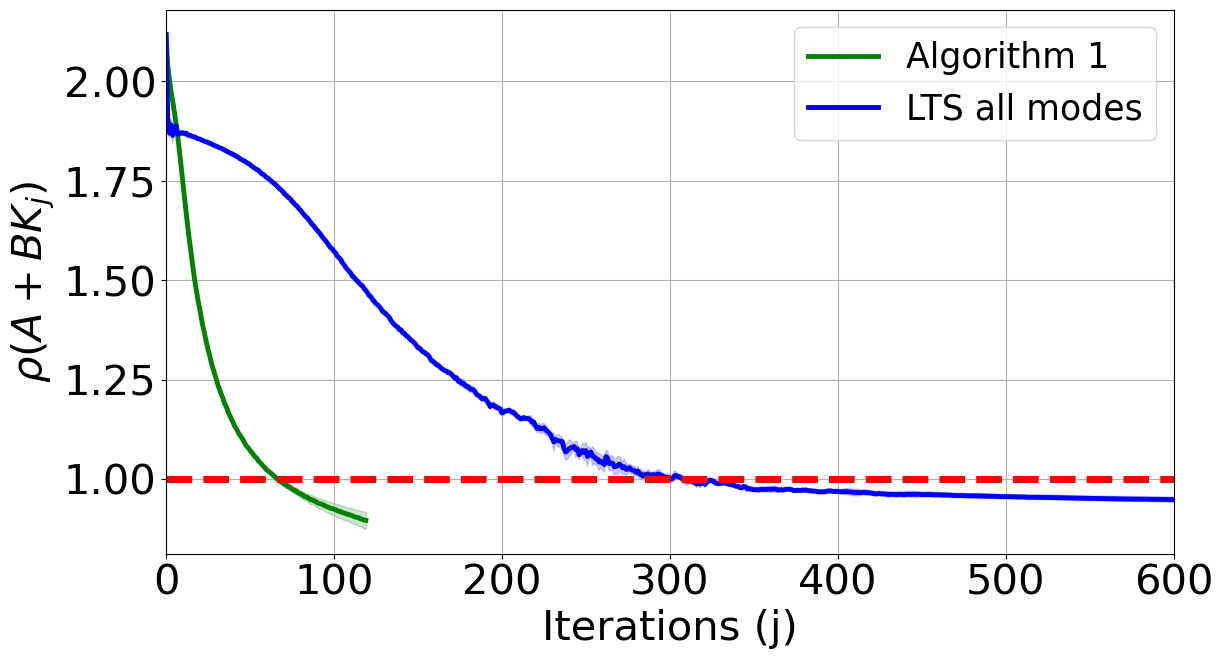

In [98]:
plt.figure(figsize=(13,8))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(sr1s, axis=0)
sem_1 = np.std(sr1s, axis=0) / np.sqrt(sr1s.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(sr2s, axis=0)
sem_2 = np.std(sr2s, axis=0) / np.sqrt(sr2s.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(sr2s, axis=0)
sem_2 = np.std(sr2s, axis=0) / np.sqrt(sr2s.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2
dim = 120
plot_1=plt.plot(np.arange(len(mean_1[0:dim])), mean_1[0:dim], label=r'Algorithm 1', color='green', linewidth=3.5)
fill_1=plt.fill_between(np.arange(len(mean_1[0:dim])), mean_1[0:dim]-ci_1[0:dim], mean_1[0:dim]+ci_1[0:dim], color='green', alpha=0.2)

plot_2=plt.plot(np.arange(len(mean_2)), mean_2, label=r'LTS all modes', color='blue', linewidth=3.5)
fill_2=plt.fill_between(np.arange(len(mean_2)), mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)

plt.plot(np.arange(dim2sr), np.ones(dim2sr), linestyle='--', color='red', linewidth=5)


plt.ylabel(r'$\rho(A+BK_{j})$',fontsize=30)
plt.xlabel('Iterations (j)',fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.xlim(0, 600)

plt.legend(fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3]  
labels = labels[:3]
plt.legend(handles=handles, labels=labels,fontsize=25)
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig("spectral_radius_cartpole.pdf")

$\textbf{Discount factor:}$

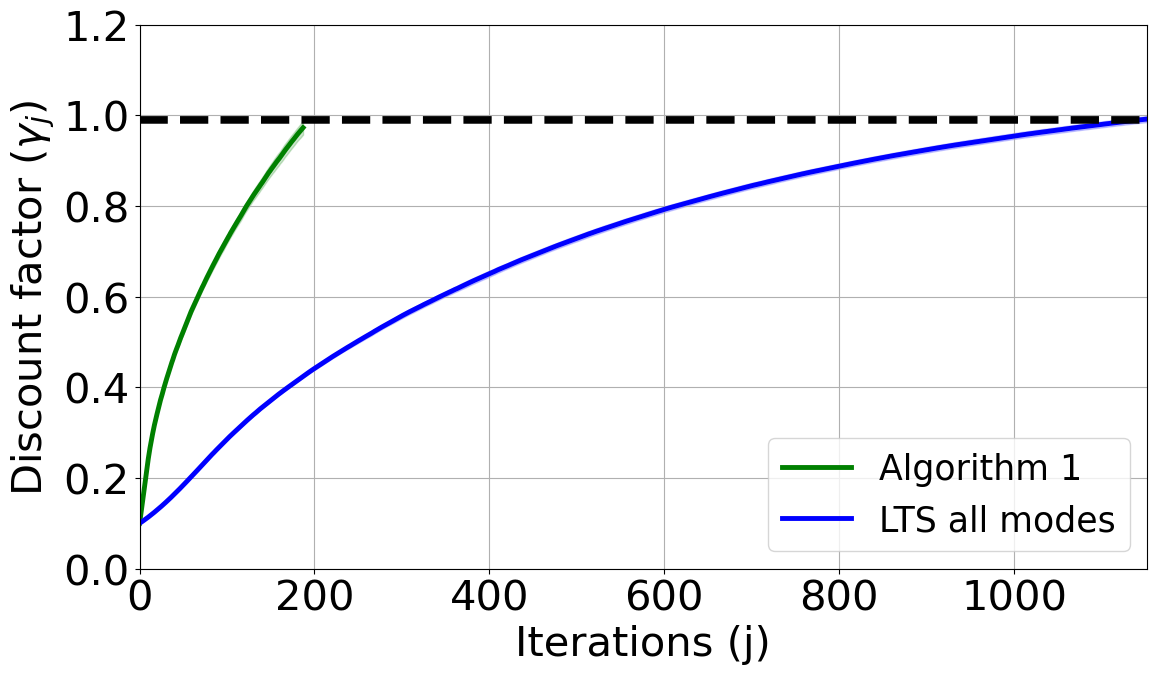

In [99]:
plt.figure(figsize=(13,8))

# Calculate mean and standard error of the mean (SEM)
mean_1 = np.mean(gammas1r, axis=0)
sem_1 = np.std(gammas1r, axis=0) / np.sqrt(gammas1r.shape[0])

# Calculate 95% confidence intervals
ci_1 = 1.95*sem_1

# Calculate mean and standard error of the mean (SEM)
mean_2 = np.mean(gammas2r, axis=0)
sem_2 = np.std(gammas2r, axis=0) / np.sqrt(gammas2r.shape[0])

# Calculate 95% confidence intervals
ci_2 = 1.95*sem_2


plot_1=plt.plot(np.arange(len(mean_1)), mean_1, label=r'Algorithm 1', color='green', linewidth=3.5)
fill_1=plt.fill_between(np.arange(len(mean_1)), mean_1-ci_1, mean_1+ci_1, color='green', alpha=0.2)

plot_2=plt.plot(np.arange(len(mean_2)), mean_2, label=r'LTS all modes', color='blue', linewidth=3.5)
fill_2=plt.fill_between(np.arange(len(mean_2)), mean_2-ci_2, mean_2+ci_2, color='blue', alpha=0.2)


plt.plot(np.arange(dim2g), 0.99*np.ones(dim2g), linestyle='--', color='black', linewidth=5.5)

plt.ylabel(r'Discount factor $(\gamma_j)$',fontsize=30)
plt.xlabel('Iterations (j)',fontsize=30)
plt.tick_params(axis='both', labelsize=30)
plt.xlim(0, dim2g)
plt.ylim(0, 1.2)

plt.legend(loc='lower right', fontsize=25)
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:3] 
labels = labels[:3]
plt.legend(loc='lower right',handles=handles, labels=labels,fontsize=25)
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig("gamma_cartpole.pdf")